# Analysis on Final Dataset

The main problem is that I have to go through multiple files and if each file naturally causes such high degree networks, it is good to initially ignore these and see if the static cut-off approach is correct!

In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import os
import pathlib
import glob

import json

import networkx as nx
import igraph
import networkx.algorithms.community as nx_comm

print(nx.__version__)
print(igraph.__version__)

import random

import re
import uuid

import imageio

2.6.3
0.9.9


Of course, there is always a slight change in the code which in the end makes it look repetative. Trying to avoid that

## Getting the information among all files

It is easy, but the original functions need to be changed and adjusted. We have to obtain the distinct authors for each file, combine them together check again for distinct authors again. It turns out that there are greek, russian an arabic people in it.

This cell gives it for individual files

In [2]:
def getUniqueAuthors(data, limit=20):
    """
    Get Unique Authors for given paper
    Needs to be done after each batch and another numpy.unique after that
    
    INPUT:
        data (json): contains publications information
    OUTPUT:
        temp_mem: contains unique authors from one batch.  
    
        
    """
    temp_mem = []
    r = re.compile(r"\s+", re.MULTILINE)
    count = 0
    for i in range(len(data['content'])):
        if ('authorships' in data['content'][i].keys() ) and (limit >= len(data['content'][i]['authorships'])):       #"yes, someone forgets to fill this"
            for j in range(len(data['content'][i]['authorships'])):
                if (data['content'][i]['authorships'][j]['otype'] == 'PersonAuthorship'):
                    string_to_add = '' 
                    if 'givenName' in data['content'][i]['authorships'][j]:
                        string_to_add += str(data['content'][i]['authorships'][j]['givenName']) + ' '
                    if 'familyName' in data['content'][i]['authorships'][j]:
                        string_to_add += str(data['content'][i]['authorships'][j]['familyName'])
                    if len(string_to_add) > 0:
                        temp_mem.append(r.sub("",string_to_add))


    temp_mem = np.array(list(np.unique(temp_mem)), dtype=object)   # define it as an object
    #temp_mem = dict(zip(temp_mem, np.array(np.arange(len(temp_mem)),dtype=np.uint32 )) ) 
    return temp_mem


def getAuthorLinks(data,temp_link_list,encoder, limit=20): 
    _name_list = np.array(list(encoder.keys()))            #saving tables
    _encoded_list = np.array(list(encoder.values())) 
    
    temp_link_list = np.zeros((0,4), dtype=np.uint32)
    r = re.compile(r"\s+", re.MULTILINE)                   #for stripping some stuff

    for i in range(len(data['content'])):
        if (i+1) % 10 == 0:
            sys.stdout.write("\r {0} / {1} # {2}".format(i+1,len(data['content']), len(temp_link_list)))
            sys.stdout.flush()
        content_mem = []
        if ('authorships' in data['content'][i].keys()) and (limit >= len(data['content'][i]['authorships'])):       #"yes, someone forgets to fill this"
            for j in range(len(data['content'][i]['authorships'])):

                if (data['content'][i]['authorships'][j]['otype'] == 'PersonAuthorship'):
                    name_to_add = ''
                    string_to_add = '' 
                    #if the field extists, get the name! -> what if none of them exists? don't give anything
                    if 'givenName' in data['content'][i]['authorships'][j]:
                        name_to_add += str(data['content'][i]['authorships'][j]['givenName']) + ' '
                    if 'familyName' in data['content'][i]['authorships'][j]:
                        name_to_add += str(data['content'][i]['authorships'][j]['familyName'])
                    name_to_add = r.sub("", name_to_add)
                    _encoded = _encoded_list[_name_list == name_to_add]
                    if len(_encoded) == 1:
                        content_mem.append(_encoded[0])
                    else:
                        print("Wrong amount of authors: {} != 1 !".format(len(_encoded)))

        if (len(content_mem) > 0):
            tmp_mem = []     #save partial results as constans addition is not liked by numpy
            for j in range(len(content_mem)):
                for k in np.arange(j+1,len(content_mem)):
                    tmp_mem.append([content_mem[j],
                                    content_mem[k],
                                    data['content'][i]['publishedYear'],
                                    len(data['content'][i]['authorships'])
                                   ]
                                  )
            if (len(tmp_mem) > 0): 
                temp_link_list = np.append(temp_link_list,
                                           tmp_mem,
                                           axis=0)

    temp_link_list = np.array(temp_link_list, dtype=np.uint32)
    return temp_link_list
    

This cell combines the results from individual file processing.

In [3]:
def getFilesUniqueAuthors(loc, limit=20):
    """
    Get Unique Authors for all batches, uses getUniqueAuthors
    
    INPUT:
        loc: path to the batches' folder
    OUTPUT:
        uniqueAuthorsEncoded: unique authors from all batches
    
    
    """
    uniqueAuthors = np.array([], dtype=object)   #initiate the container 
    files = os.listdir(loc)                      #get files in the given folder
    
    assert len(files) >= 1, "No files found! 1 >= {}".format(len(files))
    for i in range(len(files)):
        sub_path = loc + "/" + files[i]
        print(sub_path)
    
    for i in range(len(files)):
        #technically os.listdir lists everything in the folder, not only files 
        #i have to try to open them
        sub_path = loc + "/" + files[i]
        
        try:       
            file = open(sub_path,"rt",encoding="utf-8") #this is the correct way to open
            data = json.load(file)                                      #use json library to open
            file.close()                                                #close immidiately
        except:
            print("Cannot open {}".format(sub_path))
            pass
        
        #proceed 
        batchUniqueAuthors = getUniqueAuthors(data, limit=limit)
        uniqueAuthors = np.append( uniqueAuthors, batchUniqueAuthors )

        sys.stdout.write("\rFILE: {}\t{}/{} -> {} / {}\t\t\t\t".format(sub_path,
                                                               i+1,
                                                               len(files),
                                                               len(batchUniqueAuthors),
                                                               len(uniqueAuthors)))
        sys.stdout.flush()

    
            
    
    #when finished, use np.unqiue again
    bashedAmount = len(uniqueAuthors)
    
    uniqueAuthors = np.unique(uniqueAuthors)
    uniqueAuthorsEncoded = dict(zip(uniqueAuthors, np.array(np.arange(len(uniqueAuthors)), dtype=np.uint32)))
    
    print("{} to {} actually exists".format(bashedAmount,len(uniqueAuthors)))
    return uniqueAuthorsEncoded

def getFilesAuthorLinks(loc, encoder, limit=20):
    """
    Gets links beteen Unique authors to 
    
    INPUT:
        temp_link_list: contains edges
        encoder: list with encoded unique authors
        limit: limit to ignore pubications by comparing to their authourCount
    
    OUTPUT:
        VOID: modifies temp_link_ist accordingly
    
    """
    tmp_lnk_lst = np.zeros((0,4), dtype=np.uint32)      #burning in datatype
    files = os.listdir(loc)
    
    for i in range(len(files)):
        #technically os.listdir lists everything in the folder, not only files 
        #i have to try to open them
        sub_path = loc + "/" + files[i]
        
        try:       
            file = open(sub_path,"rt",encoding="utf-8") #this is the correct way to open
            data = json.load(file)                                      #use json library to open
            file.close()                                                #close immidiately
        except:
            print("Cannot open {}".format(sub_path))
            pass
        
        #proceed 
        batchAuthorLinks = getAuthorLinks(data=data, temp_link_list=tmp_lnk_lst, encoder=encoder, limit=limit)
        tmp_lnk_lst = np.append( tmp_lnk_lst, batchAuthorLinks, axis=0 )
        print("\tFILE: {}\t{}/{} -> {}/{}\t\t\t\t".format(sub_path,
                                                               i+1,
                                                               len(files),
                                                               len(batchAuthorLinks),
                                                               len(tmp_lnk_lst)
                                                               ))

    
    #it seems like here somehow self-loops are passed, so we should exclude them!
    tmp_lnk_lst = tmp_lnk_lst[~(tmp_lnk_lst[:,0] == tmp_lnk_lst[:,1])]
    
    return tmp_lnk_lst

In [4]:
path = "data/final"

_UniqueAuthors = getFilesUniqueAuthors(loc=path, limit=20)

data/final/publications_1.json
data/final/publications_10.json
data/final/publications_11.json
data/final/publications_12.json
data/final/publications_13.json
data/final/publications_14.json
data/final/publications_2.json
data/final/publications_3.json
data/final/publications_4.json
data/final/publications_5.json
data/final/publications_6.json
data/final/publications_7.json
data/final/publications_8.json
data/final/publications_9.json
FILE: data/final/publications_9.json	14/14 -> 7111 / 95824				95824 to 51450 actually exists


In [5]:
_UniqueAuthors.keys

<function dict.keys>

**NOTE**: as it turns out, there are many people that are under the same created label, with multiple names. Like `A.Szabo` is `A.Szabó` and `András Szabó` at the same time. This cannet be narrowed with the usage of english alphabet because ther are foreigners that cannot have their name to be converted into the english alphabet.

In [6]:
tmp_lnk_lst = getFilesAuthorLinks(loc=path, encoder = _UniqueAuthors, limit=20)

 5000 / 5000 # 27772	FILE: data/final/publications_1.json	1/14 -> 27773/27773				
 5000 / 5000 # 22276	FILE: data/final/publications_10.json	2/14 -> 22276/50049				
 5000 / 5000 # 28170	FILE: data/final/publications_11.json	3/14 -> 28191/78240				
 5000 / 5000 # 26406	FILE: data/final/publications_12.json	4/14 -> 26406/104646				
 5000 / 5000 # 26564	FILE: data/final/publications_13.json	5/14 -> 26585/131231				
 2160 / 2166 # 11484	FILE: data/final/publications_14.json	6/14 -> 11541/142772				
 5000 / 5000 # 24127	FILE: data/final/publications_2.json	7/14 -> 24127/166899				
 5000 / 5000 # 24434	FILE: data/final/publications_3.json	8/14 -> 24489/191388				
 5000 / 5000 # 23651	FILE: data/final/publications_4.json	9/14 -> 23651/215039				
 5000 / 5000 # 24124	FILE: data/final/publications_5.json	10/14 -> 24124/239163				
 5000 / 5000 # 25233	FILE: data/final/publications_6.json	11/14 -> 25233/264396				
 5000 / 5000 # 26957	FILE: data/final/publications_7.json	12/14 -> 26957/291353				

In [7]:
tmp_lnk_lst[0,:]

array([22082, 13837,  2014,     8], dtype=uint32)

In [8]:
len(tmp_lnk_lst)

338133

In [9]:
len(tmp_lnk_lst[(tmp_lnk_lst[:,0] == tmp_lnk_lst[:,1])])

0

### Saving the linklist

In [31]:
with open("partial_results/multiconnected_linklist.txt", "wb") as f:
    np.savetxt(f, tmp_lnk_lst, fmt='%d')

Seems to be correct, let's progress with the original stuff

## Investigating MTID

In [19]:
mtid_cont = np.array([], dtype=np.uint32)
files = os.listdir(path)
loc = path
count = 0
    
for i in range(len(files)):

    sub_path = loc + "/" + files[i]
        
    try:       
        file = open(sub_path,"rt",encoding="utf-8") #this is the correct way to open
        data = json.load(file)                                      #use json library to open
        file.close()                                                #close immidiately
    except:
        print("Cannot open {}".format(sub_path))
        pass
        
    #proceed 
    temp_mem = []
    for i in range(len(data['content'])):
        if 'authorships' in data['content'][i].keys():
            for j in range(len(data['content'][i]['authorships'])):
                if 'mtid' in data['content'][i]['authorships'][j].keys():
                    temp_mem.append(data['content'][i]['authorships'][j]['mtid'])
                    count+=1
                       
    mtid_cont = np.append(mtid_cont, np.unique(temp_mem) )

Cannot open data/final/publications_12.json
Cannot open data/final/publications_13.json
Cannot open data/final/publications_14.json
Cannot open data/final/publications_2.json
Cannot open data/final/publications_3.json
Cannot open data/final/publications_4.json


KeyboardInterrupt: 

In [16]:
asd = np.unique(mtid_cont)
len(asd)

2405149

In [18]:
mtid_cont.shape

(2405149,)

In [21]:
print(count)

2405149


This means that mtid is unique in some different way, but cannot be used as a way to encode the different authors.

# Indicators

## Degree Distribution

In [10]:
#create the grahp object
sample_graph = nx.Graph()
sample_graph.add_edges_from(tmp_lnk_lst[:,0:2])

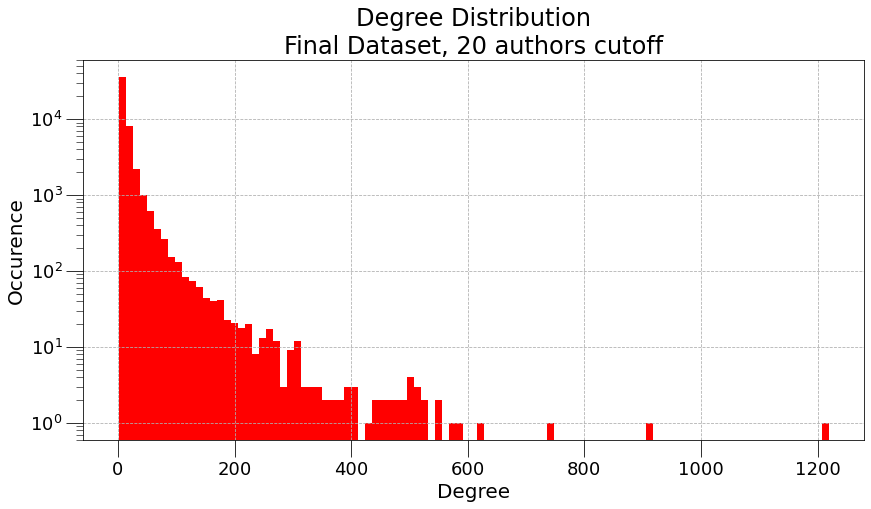

In [239]:
plt.figure(figsize=(14,7))

plt.title("Degree Distribution\nFinal Dataset, 20 authors cutoff", fontsize=24)

_, deg = np.unique(tmp_lnk_lst[:,0:2].flatten(), return_counts=True)
plt.hist(deg, bins=101, color="red")

plt.xlabel("Degree", fontsize=20)
plt.ylabel("Occurence", fontsize=20)
plt.tick_params(labelsize=18,axis="both",size=17)
plt.tick_params(which="minor",axis="both",size=7)

#plt.xscale("log")
plt.yscale("log")
plt.grid(linestyle="--")

plt.savefig("figs/k_dist_from_realdata.pdf",format="pdf",bbox_inches="tight")
plt.show()

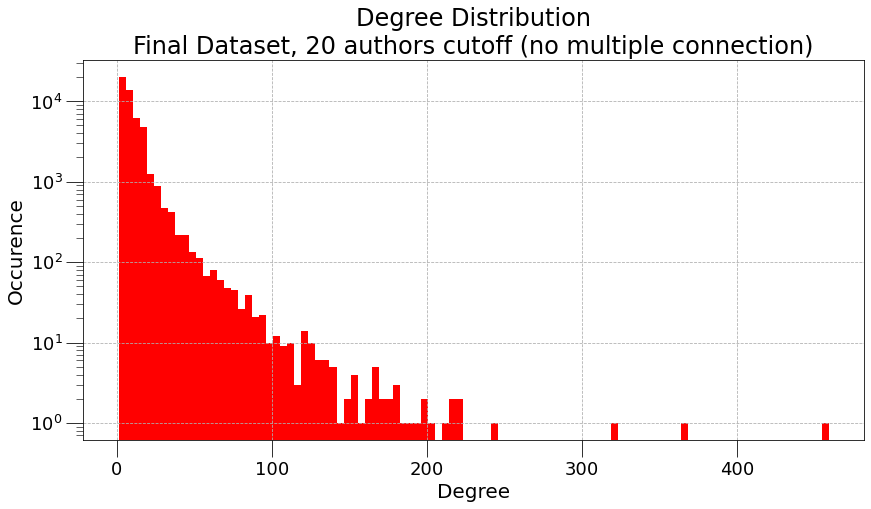

In [240]:
np.array([list(deg)[1] for deg in sample_graph.degree])

plt.figure(figsize=(14,7))

plt.title("Degree Distribution\nFinal Dataset, 20 authors cutoff (no multiple connection)", fontsize=24)

plt.hist(np.array([list(deg)[1] for deg in sample_graph.degree]), bins=101, color="red")

plt.xlabel("Degree", fontsize=20)
plt.ylabel("Occurence", fontsize=20)
plt.tick_params(labelsize=18,axis="both",size=17)
plt.tick_params(which="minor",axis="both",size=7)

#plt.xscale("log")
plt.yscale("log")
plt.grid(linestyle="--")

plt.savefig("figs/k_dist_from_realdata_no_weight.pdf",format="pdf",bbox_inches="tight")
plt.show()

This seems like that on log-log scale, a line could be fitted $\rightarrow$ **Power function** could be fitted.

**NOTE**: 

the little difference present in the two distributions are the following: in one, I allow multiple connections, in the other, networkx doesn't. Which one is correct? In my interpretation, it is allowed for diefferent authors to work together on multiple ocasions. Networkx's simple approach could be understood with the following argument: did they are work together or not. Of course, weighting the network would make it more visible which person worked with which more often, but we are only interested in the estabilishment of the connection!

## Graph Representation

It could be handy to see how it looks like with the spiral layout.

In [19]:
len(list(sample_graph.nodes))

48931

**This one runs for a long time**

In [ ]:
#generate the positions of the spiral layout with initial 50 iterations
pos = nx.spring_layout(sample_graph)

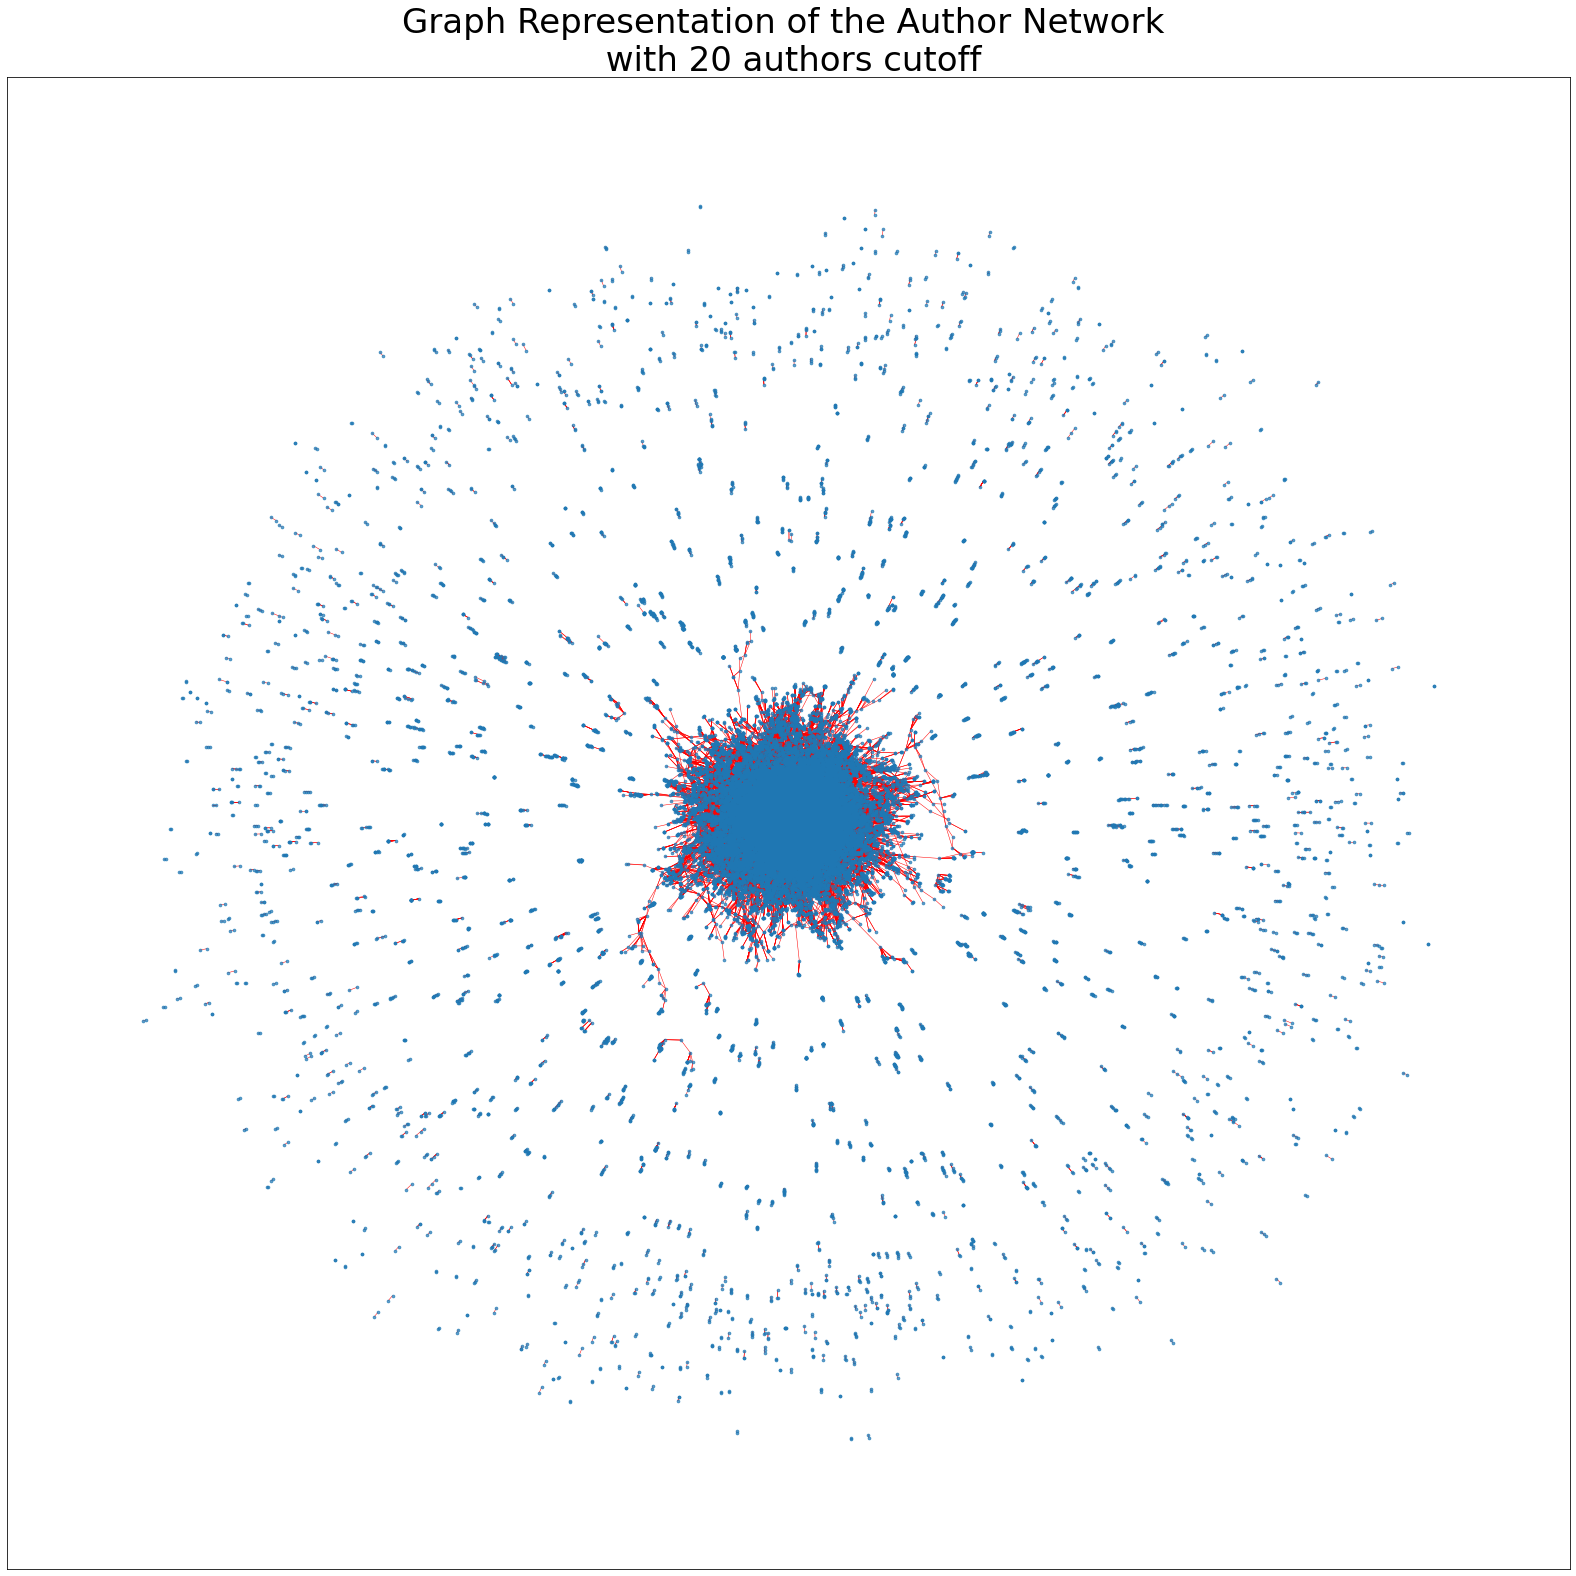

In [24]:
#get the figure
fig = plt.figure(figsize=(22,22))

plt.title("Graph Representation of the Author Network \n with 20 authors cutoff", fontsize=34)



nx.draw_networkx_nodes(sample_graph,
                      pos,
                      nodelist = np.array(sample_graph.nodes),
                      node_size=7,
                      alpha=0.7
                      )

nx.draw_networkx_edges(sample_graph,
                      pos,
                      width=0.5,
                      edgelist=tmp_lnk_lst[:,0:2],
                      edge_color='r',
                      arrows=False)

fig.tight_layout()

plt.savefig("figs/networkx_author_network_from_final.pdf", format="pdf", bbox_inches="tight")

#needs some modifications, but starts to look acceptable

plt.show()

## Shortest distance

This seems to be tricky, because it calculates the `average_shortest_distance_path` for a graph or individually for each node.

In [20]:
test1 = nx.single_source_shortest_path_length(sample_graph,1)

In [21]:
p1,p2 = np.unique(list(test1.values()), return_counts=True)

In [22]:
p1*p2, np.mean(p1*p2)

(array([     0,      3,     40,    309,   2040,  14865,  81534, 105462,
         54528,  20799,   7700,   2486,   1164,    819,    420,    120,
            32], dtype=int64),
 17195.352941176472)

In [23]:
np.mean(list(test1.values()))

6.8639288062364985

So as it turns out, I was mistaken about the average shorted path calculation. p1 $\cdot$ p2  is almost correct, except that it should have been divided by sum(p2)... Of course It didn't make any sense. This makes the usage of numpy.unique obsilate.

In [24]:
count=0
for i in sample_graph.nodes:
    print(i)
    count+=1
    if count > 10:
        break

22082
13837
1833
21515
40369
30830
29942
8879
23127
37435
48635


As it seems, I have to do this for every node, make averages for each node and then a histogramm.

In [45]:
avg_container = []            #container for 
count = 0
print("\nStarting!")
for i in sample_graph.nodes:
    if ( count % 10 == 0):
        sys.stdout.write('\r@ {} / {}'.format(count,len(sample_graph.nodes)))
        sys.stdout.flush()
    
    node_n_length = nx.single_source_shortest_path_length(sample_graph,i)                  #get the path for a node
    #path_l, path_c = np.unique(list(node_n_length.values()), return_counts=True)          #get the lenghts and counts of lenght
    avg_container.append([i, np.mean(list(node_n_length.values()))])                       #save it for each node
    count+=1
    
print("\nFinished")

avg_shortest_path_local = np.array(avg_container)

#save it as it takes a huge amount of time to calculate
np.savetxt( "partial_results/avg_shortest_path_per_node.csv",avg_shortest_path_local,delimiter=",")


Starting!
@ 48930 / 48931
Finished


In [2]:
#load it in
avg_shortest_path_local = np.loadtxt("partial_results/avg_shortest_path_per_node.csv",delimiter="," )

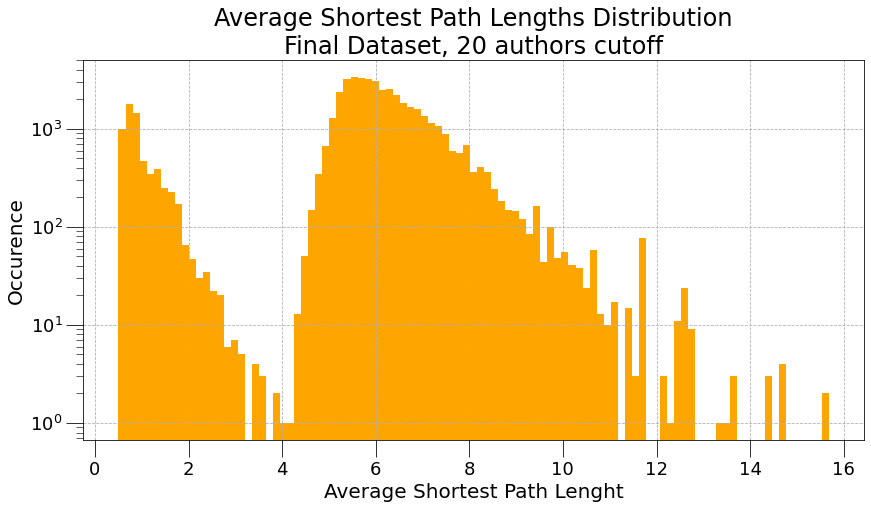

In [26]:
plt.figure(figsize=(14,7))

plt.title("Average Shortest Path Lengths Distribution\nFinal Dataset, 20 authors cutoff", fontsize=24)

plt.hist(avg_shortest_path_local[:,1], bins=101, color="orange")

plt.xlabel("Average Shortest Path Lenght", fontsize=20)
plt.ylabel("Occurence", fontsize=20)
plt.tick_params(labelsize=18,axis="both",size=17)
plt.tick_params(which="minor",axis="both",size=7)

#plt.xscale("log")
plt.yscale("log")
plt.grid(linestyle="--")

plt.savefig("figs/avg_path_dist_from_realdata.pdf",format="pdf",bbox_inches="tight")
plt.show()

First breadth search could come handy to see why an avg. distance is such a high number for a given node. **Maybe take a look into it too**!

Seems to be very suspicious. Chains?

Let's take a look into what part of it comes from the giant component!

In [9]:
components = [c for c in sorted(nx.connected_components(sample_graph), key=len, reverse=True)]
#list(components[0])

In [30]:
#saving the giant component
giant_component_linklist = np.array(list(sample_graph.edges(components[0])))

with open("partial_results/giant_component.txt", "wb") as f:
    np.savetxt(f, giant_component_linklist, fmt='%d')

In [14]:
giant_comp_avg_sh_paths = []
for i in list(components[0]):
    giant_comp_avg_sh_paths.append([i, avg_shortest_path_local[:,1][avg_shortest_path_local[:,0] == i ][0]])
    
giant_comp_avg_sh_paths = np.array(giant_comp_avg_sh_paths)

In [15]:
avg_shortest_path_local[:,1][avg_shortest_path_local[:,0] == 0]

array([7.65548981])

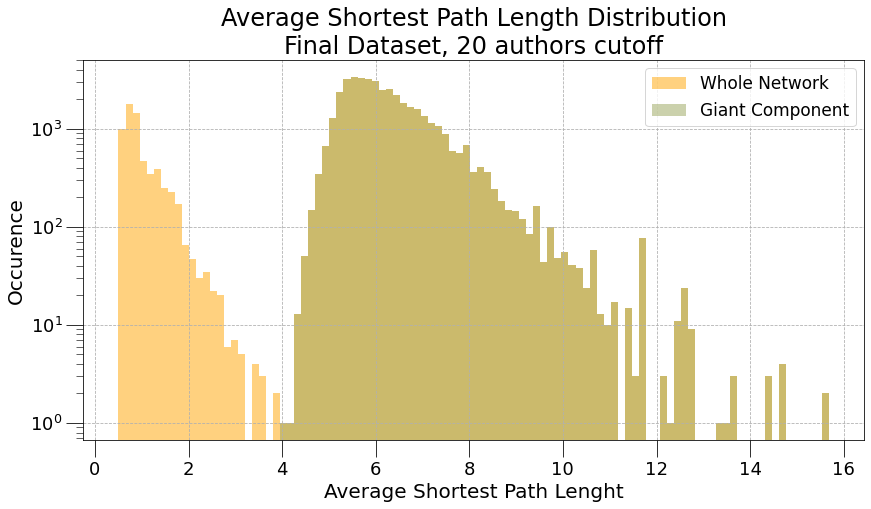

In [27]:
plt.figure(figsize=(14,7))

plt.title("Average Shortest Path Length Distribution\nFinal Dataset, 20 authors cutoff", fontsize=24) #title
 
_, bins0, _ = plt.hist(avg_shortest_path_local[:,1], bins=101, color="orange", label='Whole Network', alpha=0.5)  #whole network
plt.hist(giant_comp_avg_sh_paths[:,1], bins=bins0, color="#99a55a", label="Giant Component", alpha=0.5)          #just the giant component

plt.xlabel("Average Shortest Path Lenght", fontsize=20)
plt.ylabel("Occurence", fontsize=20)
plt.tick_params(labelsize=18,axis="both",size=17)
plt.tick_params(which="minor",axis="both",size=7)

#plt.xscale("log")
plt.yscale("log")            #log scale for easier comparison
plt.legend(loc='best', fontsize=17)
plt.grid(linestyle="--")

plt.savefig("figs/avg_path_dist_plus_comp_from_realdata.pdf",format="pdf",bbox_inches="tight")
plt.show()

### Breadth First Search

Let's take a look into why it looks like that! Let's use `single_source_shortest_path` to explain what's going on with this and use the highest avg. shortest path node as a source and see how long the paths are!

In [47]:
giant_comp_avg_sh_paths[:,0][giant_comp_avg_sh_paths[:,1] == np.max(giant_comp_avg_sh_paths[:,1])]

array([ 9120., 34081.])

In [48]:
sourced_shortest_paths = nx.single_source_shortest_path(sample_graph,source=9120)

In [54]:
sourced_shortest_paths_lengths = [len(i) for i in list(sourced_shortest_paths.values())]
print(np.max(sourced_shortest_paths_lengths))

26


**26**? It is a really long path. It seems like it do to these chains of nodes connecting to high degree nodes and then again to the chain. The first couple of nodes for each path are the same so this particular node is at the end of the chain!

## Components

Let's see what components are in in our network. We saw the graph representation, let's see the components that are present in it!.

In [13]:
comps = nx.number_connected_components(sample_graph)
print(comps)

1420


So we have 1420 components in it! Lot of small groups and on giant.

### Components sizes

Let's see their sizes and get the largest one too!

In [25]:
component_sizes = [len(c) for c in sorted(nx.connected_components(sample_graph), key=len, reverse=True)]

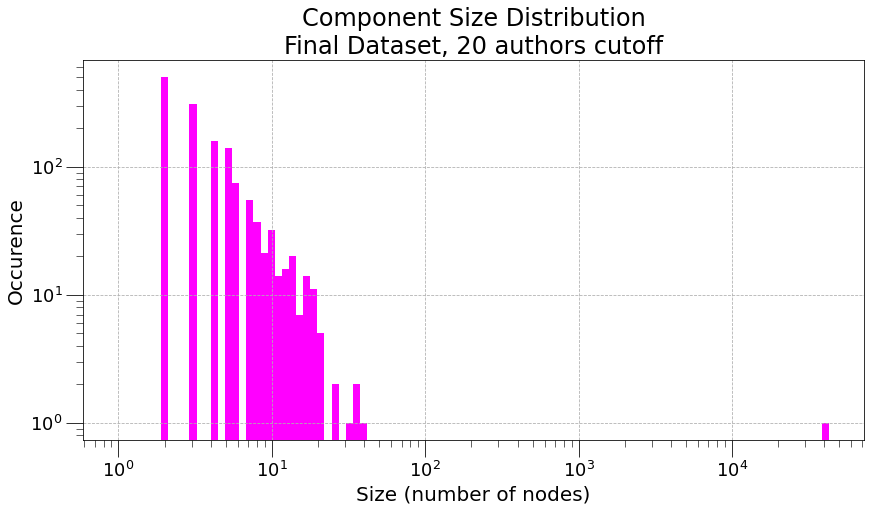

In [22]:
plt.figure(figsize=(14,7))

plt.title("Component Size Distribution\nFinal Dataset, 20 authors cutoff", fontsize=24)

plt.hist(component_sizes, bins=np.logspace(np.log10(1),np.log10(max(component_sizes)), 101), color="magenta")

plt.xlabel("Size (number of nodes)", fontsize=20)
plt.ylabel("Occurence", fontsize=20)
plt.tick_params(labelsize=18,axis="both",size=17)
plt.tick_params(which="minor",axis="both",size=7)

plt.xscale("log")
plt.yscale("log")
plt.grid(linestyle="--")

plt.savefig("figs/comp_size_dist_from_realdata.pdf",format="pdf",bbox_inches="tight")
plt.show()

### Smaller components in the graph

Let's see how these smaller components look like in the graph. First component is the giant one as I have it sorted before hand. I want to look at the second biggest component and 3 random ones.

In [29]:
components = [c for c in sorted(nx.connected_components(sample_graph), key=len, reverse=True)]
#can't give seed to choosen comps directly

choosen_comps = []
choosen_comps.append(list(components[1]))
large_enough = np.array(components[2:])[np.array(component_sizes[2:]) > 3 ]
for i in range(3):
    choosen_comps.append(list(np.random.choice(large_enough)))
    
#now I have to process these node to get edges
#will the data struct look ugly? YES TOTALLY

collector = [] #this will collect the individual results
for comp in choosen_comps:
    individual = np.zeros((0,2),dtype=np.uint32)
    #go through the the component's nodes
    for j in comp:
        edge_view = sample_graph.edges(j)
        for edge in edge_view:
            individual = np.append(individual, np.array([list(edge)]), axis=0)
    
    #cleaning
    for i in range(int(len(individual) / 2)):
        res = individual[i] == individual[:,::-1]   #compare one row to the others
        #if both columns has both true -> intersect -> see the true -> downsize
        individual = individual[~(res[:,0] * res[:,1] == True)]  
        #arguably this is not the best solution, but it does the trick!       
    
    collector.append(individual)
    
print("The {} components consist of: {}, {}, {}, {} bidirectional edges".format(len(collector),
                                                                                len(collector[0]),
                                                                                len(collector[1]),
                                                                               len(collector[2]),
                                                                               len(collector[3])))

#this will be good for testing
with open("partial_results/second_largest_component.txt", "wb") as f:
    np.savetxt(f, np.array(collector[0]), fmt='%d')

The 4 components consist of: 150, 55, 10, 10 bidirectional edges


In [24]:
graph_set = []
positions = []

for comps in collector:
    G0 = nx.Graph()
    G0.add_edges_from(comps)
    graph_set.append(G0)
    
for graph in graph_set:
    positions.append(nx.spring_layout(graph))

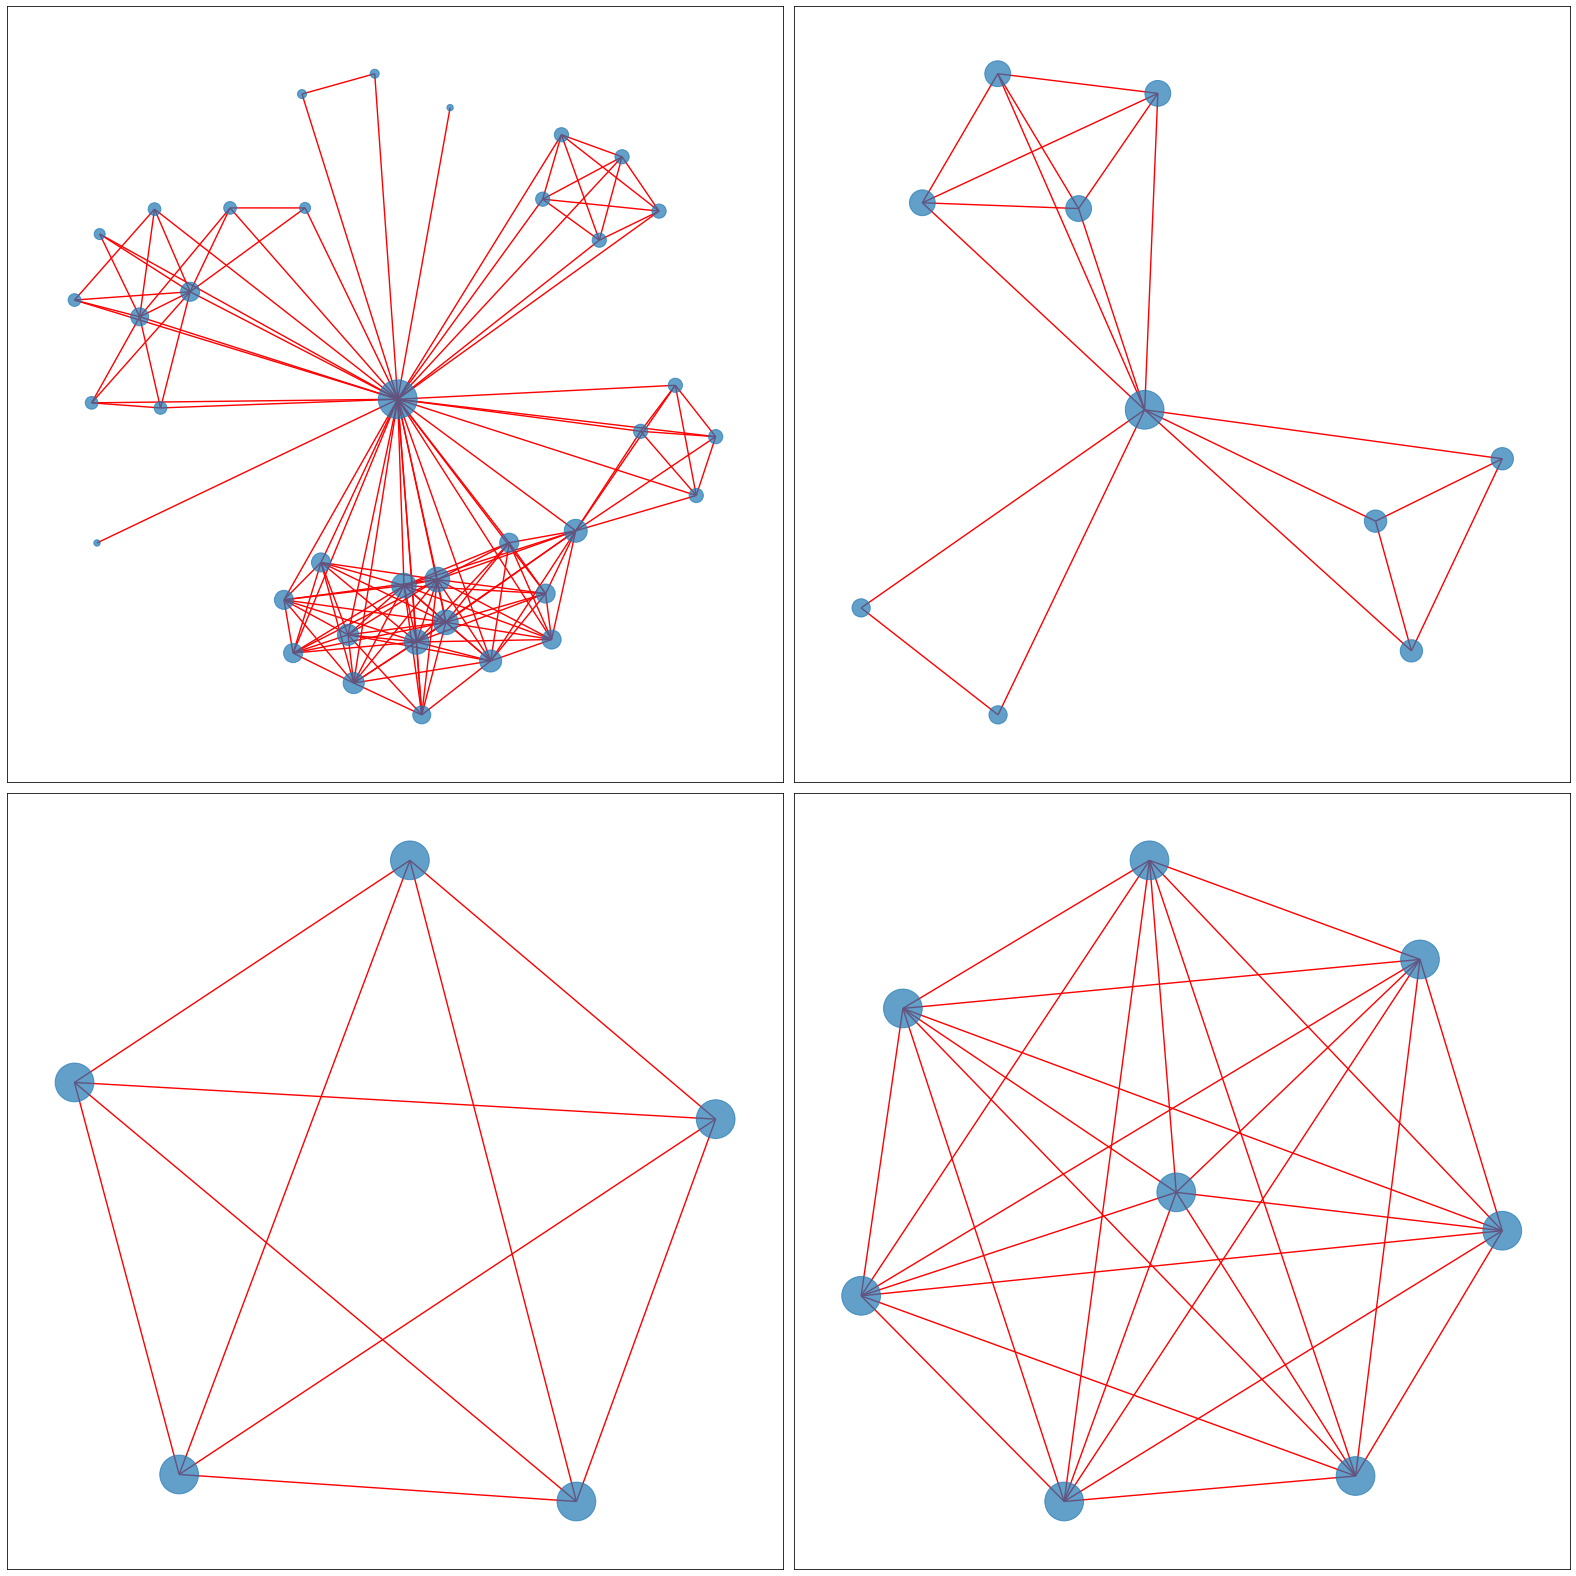

In [25]:
#get the figure
fig,axes = plt.subplots(nrows=2, ncols=2, figsize=(22,22))

#plt.title("Components Graph Representation of the Author Network \n with 20 authors cutoff", fontsize=34)

ax = axes.flatten()

for i in range(len(ax)):
    nx.draw_networkx_nodes(graph_set[i],
                          positions[i],
                          #nodelist = np.array(sample_graph.nodes),
                          node_size=(list([list(node_n_deg)[1] for node_n_deg in graph_set[i].degree])
                                     / 
                                     np.max(list([list(node_n_deg)[1] for node_n_deg in graph_set[i].degree]))) *1500,
                          alpha=0.7,
                          ax=ax[i])

    nx.draw_networkx_edges(graph_set[i],
                          positions[i],
                          width=1.4,
                          #edgelist=tmp_lnk_lst[:,0:2],
                          edge_color='r',
                          arrows=False,
                          ax=ax[i])

fig.tight_layout()

plt.savefig("figs/component_representation.pdf", format="pdf", bbox_inches="tight")

#needs some modifications, but starts to look acceptable

plt.show()

With these being cherry-picked to be shown, they seem to be a good candiates to show how the smaller components are structured.

### Component sizes in time-evolution

Let's see how does this change in time! Networkx will help with this as I have to slice the array for the given years, but it is not advised to do it for every year. It's okey to do it for every second or third year.

In [37]:
years[::-1]

array([2023, 2022, 2021, 2020, 2019, 2018, 2017, 2016, 2015], dtype=int64)

In [41]:
np.arange(len(years[::-2][::-1]))[::-1]

array([4, 3, 2, 1, 0])

In [32]:
comp_sizes_in_years = []
for year in years[::-2][::-1]:
    year_graph = nx.Graph()
    year_graph.add_edges_from(tmp_lnk_lst[:,:2][year > tmp_lnk_lst[:,2]])
    comp_sizes_in_years.append([len(c) for c in sorted(nx.connected_components(year_graph), key=len, reverse=True)])

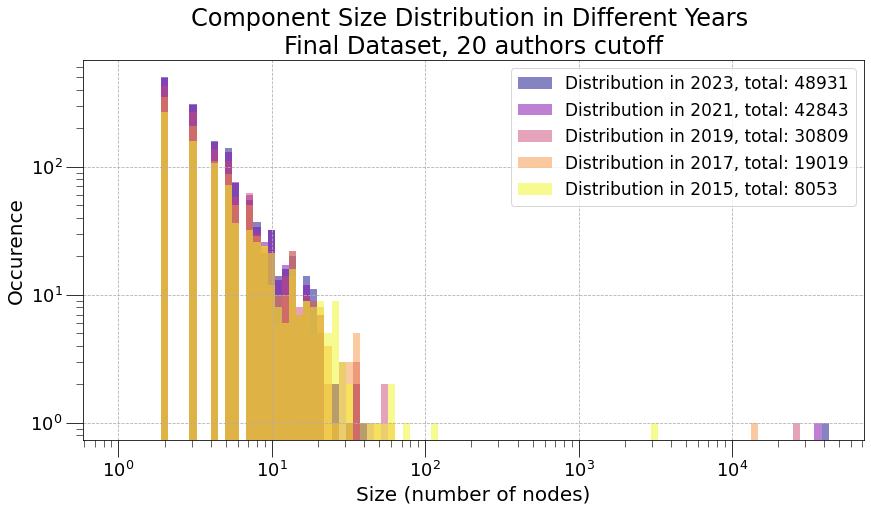

In [59]:
colors = plt.cm.plasma(np.linspace(1,0,len(comp_sizes_in_years)))
edges = np.histogram_bin_edges(comp_sizes_in_years[-1], bins=np.logspace(np.log10(1), np.log10(max(comp_sizes_in_years[-1])), 101),)

plt.figure(figsize=(14,7))

plt.title("Component Size Distribution in Different Years \nFinal Dataset, 20 authors cutoff", fontsize=24)

for i in np.arange(len(years[::-2][::-1]))[::-1]:
    plt.hist(comp_sizes_in_years[i],
            bins=edges,
            color=colors[i],
            alpha=0.5,
            label="Distribution in {}, total: {}".format(years[2*i], sum(comp_sizes_in_years[i]))
            )

plt.xlabel("Size (number of nodes)", fontsize=20)
plt.ylabel("Occurence", fontsize=20)
plt.tick_params(labelsize=18,axis="both",size=17)
plt.tick_params(which="minor",axis="both",size=7)

plt.legend(loc="best", fontsize=17)
plt.xscale("log")
plt.yscale("log")
plt.grid(linestyle="--")

plt.savefig("figs/comp_size_dist_in_time_evolution.pdf",format="pdf",bbox_inches="tight")
plt.show()

In [60]:
years[::-2][::-1]

array([2015, 2017, 2019, 2021, 2023], dtype=int64)

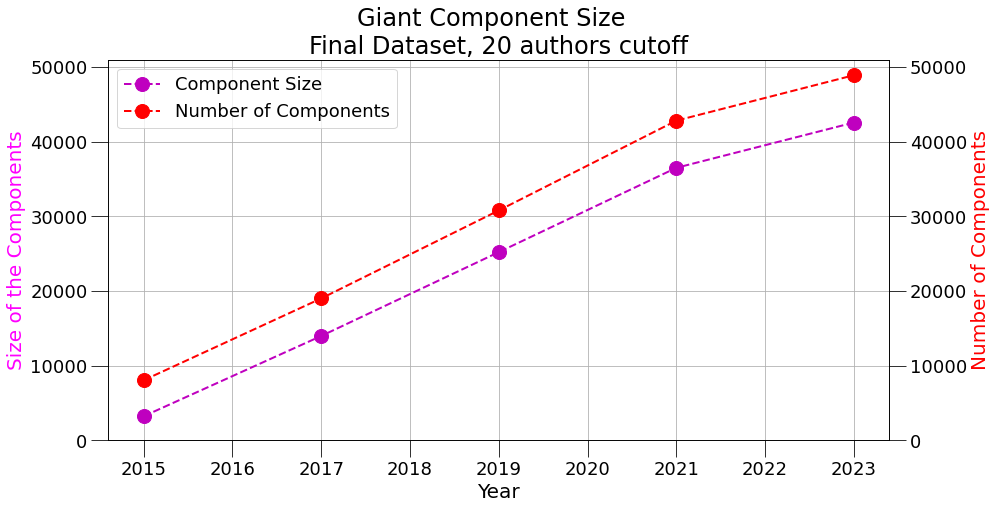

In [86]:
#let's see whats the biggest component for each year

fig, ax = plt.subplots(figsize=(14,7))

ax.set_title("Giant Component Size  \nFinal Dataset, 20 authors cutoff", fontsize=24)

plot_1 = ax.plot(years[::-2][::-1],
                 [comp_year[0] for comp_year in comp_sizes_in_years],
                 "--mo" ,
                 markersize=14,
                 linewidth=2,
                 label="Component Size")

ax.set_xlabel("Year", fontsize=20)
ax.set_ylabel("Size of the Components",color="magenta", fontsize=20)
ax.tick_params(labelsize=18,axis="both",size=17)
ax.tick_params(which="minor",axis="both",size=7)
ax.set_ylim(0, 51000)
ax.grid()

ax2 = ax.twinx()
plot_2 = ax2.plot(years[::-2][::-1],
                 [sum(comp_year) for comp_year in comp_sizes_in_years],
                 "--ro" ,
                 markersize=14,
                 linewidth=2,
                 label="Number of Components")

ax2.set_ylabel("Number of Components",color="red", fontsize=20)
ax2.set_ylim(0, 51000)
ax2.tick_params(labelsize=18,axis="both",size=17)
ax2.tick_params(which="minor",axis="both",size=7)

lns = plot_1 + plot_2
labels = [l.get_label() for l in lns]
plt.legend(lns, labels, loc="best", fontsize=18)

plt.savefig("")
plt.show()

In [70]:
[sum(comp_year) for comp_year in comp_sizes_in_years]

[8053, 19019, 30809, 42843, 48931]

In [71]:
[comp_year[0] for comp_year in comp_sizes_in_years]

[3229, 13984, 25221, 36518, 42588]

It is very strange that the two line are so similar and they are pulled onto each other, they are overlapping almost perfectly.

## Small World

https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.smallworld.sigma.html#networkx.algorithms.smallworld.sigma

Small World should be looked at the largest component!

**If someone looks at the results for the average shortest path distribution, it will be obvious that this network, or giant component of it does not have the small world property**

## Assortativity

It is advised to look into the assortativity of the giant component only as the little ones don't contribute to this as much and it will make the picture a bit more noisy.

The approach is straightforward: get the different degrees of the system, look through the linklist to see the nodes neightbours, and for a given node, save the sum of the degree of the node divided by the node of the degree. After that just sum up the distinct degree and partial results, and its done.

In [15]:
from scipy.optimize import curve_fit as curve_fit

In [170]:
def calcKNN(graph,nodes):
    k_nn_partials0 = np.zeros((0,2))
    count = 0
    for node in list(nodes):
        if(count % 11 == 0):
            sys.stdout.write("\r{} / {}".format(count+1,len(nodes)))
            sys.stdout.flush()
        #for each node, ge the degree
        deg = graph.degree(node)
        n_degs = []
        #get its neighbours
        neighbours = [list(edge)[1] for edge in graph.edges(node)]
        for neighbour in neighbours:
            n_degs.append(graph.degree(neighbour))
        if deg !=0:
            k_nn_partials0 = np.append(k_nn_partials0, np.array([[deg,sum(n_degs)/deg]]), axis=0)
        else:
            k_nn_partials0 = np.append(k_nn_partials0, np.array([[deg,0]]), axis=0)
        count+=1

    k_nn_partials0= np.array(k_nn_partials0)

    degrees = np.unique(np.array([list(deg)[1] for deg in graph.degree]))
    k_nn_finals0 = np.zeros((0,2))
    for deg in degrees:
        k_nn_finals0 = np.append(k_nn_finals0,
                                 np.array([[deg, sum(np.array(k_nn_partials_random[:,1][k_nn_partials0[:,0] == deg]))]]),
                                 axis=0)
    return k_nn_finals0

In [16]:
def powerFunction(x,a,b):
    return b * np.power(x, -a)

def powlaw(x, a, b) :
    return a * np.power(x, b)
def linlaw(x, a, b) :
    return a + x * b

#https://stackoverflow.com/questions/41109122/fitting-a-curve-to-a-power-law-distribution-with-curve-fit-does-not-work
#it was very obvious that my fitting is not good, so the data has to be transoformed to fit on the linear one and back to what
#we actually need.

def curve_fit_log(xdata, ydata) :
    """Fit data to a power law with weights according to a log scale"""
    # Weights according to a log scale
    # Apply fscalex
    xdata_log = np.log10(xdata)
    # Apply fscaley
    ydata_log = np.log10(ydata)
    # Fit linear
    popt_log, pcov_log = curve_fit(linlaw, xdata_log, ydata_log)
    #print(popt_log)
    # Apply fscaley^-1 to fitted data
    ydatafit_log = np.power(10, linlaw(xdata_log, *popt_log))
    # There is no need to apply fscalex^-1 as original data is already available
    return (popt_log, pcov_log, ydatafit_log)

In [19]:
#go through the nodes, categorize them by their degree, take their neightbors degree average, save and sum up partial results
k_nn_partials = np.zeros((0,2))
count = 0
for node in components[0]:
    if(count % 10 == 0):
        sys.stdout.write("\r{} / {}".format(count,len(components[0])))
        sys.stdout.flush()
    #for each node, ge the degree
    deg = sample_graph.degree(node)
    n_degs = []
    #get its neighbours
    neighbours = [list(edge)[1] for edge in sample_graph.edges(node)]
    for neighbour in neighbours:
        n_degs.append(sample_graph.degree(neighbour))
    
    k_nn_partials = np.append(k_nn_partials, np.array([[deg,sum(n_degs)/deg]]), axis=0)
    count+=1
    
k_nn_partials = np.array(k_nn_partials)

degrees = np.unique(np.array([list(deg)[1] for deg in sample_graph.degree]))
k_nn_finals = np.zeros((0,2))
for deg in degrees:
    k_nn_finals = np.append(k_nn_finals,
                            np.array([[deg, sum(np.array(k_nn_partials[:,1][k_nn_partials[:,0] == deg]))]]),
                            axis=0)

42580 / 42588

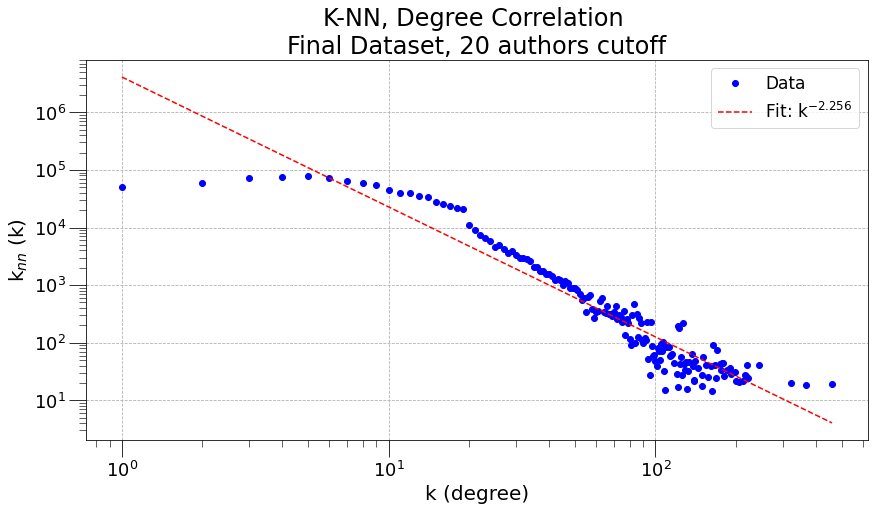

In [20]:
#curve_fit
#popt, pcov = curve_fit(powerFunction,k_nn_finals[:,0], k_nn_finals[:,1],p0 = np.asarray([-1,20**5]), maxfev=3000 )
popt_log, pcov_log, ydatafit_log = curve_fit_log(k_nn_finals[:,0],k_nn_finals[:,1])

#figure
plt.figure(figsize=(14,7))

plt.title("K-NN, Degree Correlation \nFinal Dataset, 20 authors cutoff", fontsize=24)

lab0 = "Fit: k$^{" + str(np.round(popt_log[1],3)) + "}$"

plt.plot(k_nn_finals[:,0], k_nn_finals[:,1], " bo", label="Data")
plt.plot(k_nn_finals[:,0], ydatafit_log, "--r", label=lab0)


plt.xlabel("k (degree)", fontsize=20)
plt.ylabel("k$_{nn}$ (k)", fontsize=20)
plt.tick_params(labelsize=18,axis="both",size=17)
plt.tick_params(which="minor",axis="both",size=7)

plt.xscale("log")
plt.yscale("log")
plt.legend(loc="best", fontsize=17)
plt.grid(linestyle="--")

plt.savefig("figs/k_nn_from_realdata.pdf",format="pdf",bbox_inches="tight")
plt.show()

**NOTE**: this is what it looks like a structural disassortativity. It simply there because we ignore multiple connections. If we do some randomisation, and look at the the degree correlation and it doesn't change, we can see that this disassortativity is introduced by the structure where we ignore multi-connected egdes.

### Structural disassortavity

Double edge swap doesn't work. It seems like I have to create a randomizer, that deletes edges, creates new ones with carefully watching out for already existing links.

In [140]:
#create the giant component
giant_comp = nx.Graph()
giant_comp.add_edges_from(sample_graph.edges(components[0]))

#now they are identical


#randomize it with edge swap
giant_comp_swapped2 = nx.double_edge_swap(giant_comp,                                      #graph to be swapped
                                         nswap=int(0.2*(len(giant_comp.edges))),           #amount of swaps
                                         max_tries=int(0.2*(len(giant_comp.edges)))*1000 ) #many many tries to succession

In [175]:
giant_comp_swapped1 = nx.Graph()
giant_comp_swapped1.add_edges_from(sample_graph.edges(components[0]))

#create and delete, which will make
percentage = 0.2 #percentage of links to be randomzized
swap_amount = int(percentage * len(giant_comp_swapped.edges))
swapped_count = 0
deleted_count = 0
g_nodes = list(giant_comp_swapped1.nodes)


#we choose what edges will be created -> we have to store it before hand
edges_to_be_added = []
edges_to_be_deleted = []

print("\nStarting future edges addition")
#first we have to add edges with choosing 2 nodes
#this way we eliminate the option of recreating an edge that could have been deleted
while ((swap_amount - swapped_count) != -1):
    #choose 2 random nodes
    n1, n2 = np.random.choice(g_nodes), np.random.choice(g_nodes)
    
    #check if edges exists
    if ((n1,n2) not in giant_comp_swapped1.edges) and ( (n1,n2) not in edges_to_be_added):
        if(swapped_count % 11 == 0):
            sys.stdout.write("\r{} / {}".format(swapped_count+1,swap_amount))
            sys.stdout.flush()
        edges_to_be_added.append((n1,n2))
        swapped_count+=1
    
    #no else is needed: we succed, we create. We match the combo, we go beyond it.
    
print("\nStarting deletion")
#now do the deletion. Delteion doesnt requires storing as we reduce it to the given size and grow it again
edges_to_be_deleted = np.array(list(giant_comp_swapped1.edges))[random.sample(range(len(giant_comp_swapped1.edges)), k=swap_amount)]

giant_comp_swapped1.remove_edges_from(edges_to_be_deleted)
print('\nAdding choosen edges')
giant_comp_swapped1.add_edges_from(edges_to_be_added)
print("\nFinished!")


Starting future edges addition
45035 / 45038
Starting deletion

Adding choosen edges

Finished!


This cell got separated as it does the final manipulation of the graph object

In [176]:
print(len(giant_comp.edges), len(giant_comp_swapped1.edges), len(giant_comp_swapped2.edges))
k_nn_swap_random = calcKNN(giant_comp_swapped2, giant_comp_swapped2.nodes)
k_nn_randomized = calcKNN(giant_comp_swapped1, giant_comp_swapped1.nodes)

225190 225191 225190
42582 / 42588

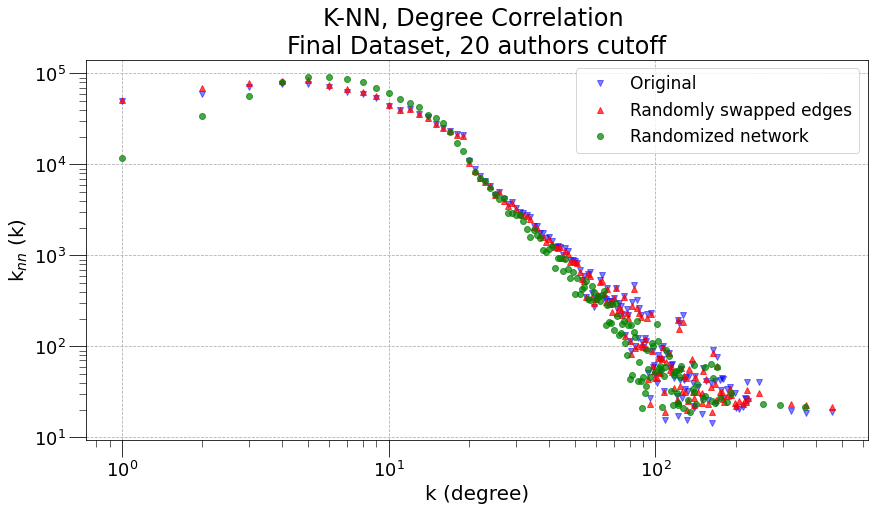

In [207]:
#figure
plt.figure(figsize=(14,7))

plt.title("K-NN, Degree Correlation \nFinal Dataset, 20 authors cutoff", fontsize=24)

lab0 = "Fit: k$^{" + str(np.round(popt_log[1],3)) + "}$"

plt.plot(k_nn_finals[:,0], k_nn_finals[:,1], " bv", label="Original", alpha=0.5)
plt.plot(k_nn_random_finals[:,0], k_nn_random_finals[:,1], " r^", label="Randomly swapped edges", alpha=0.7)
plt.plot(k_nn_randomized[:,0], k_nn_randomized[:,1], " go", label="Randomized network", alpha=0.7)


plt.xlabel("k (degree)", fontsize=20)
plt.ylabel("k$_{nn}$ (k)", fontsize=20)
plt.tick_params(labelsize=18,axis="both",size=17)
plt.tick_params(which="minor",axis="both",size=7)

plt.xscale("log")
plt.yscale("log")
plt.legend(loc="best", fontsize=17)
plt.grid(linestyle="--")

plt.savefig("figs/k_nn_original_n_random_from_realdata.pdf",format="pdf",bbox_inches="tight")
plt.show()

## Betweenness

In [32]:
nodes_n_betweenness = nx.betweenness_centrality(sample_graph,k=2000)

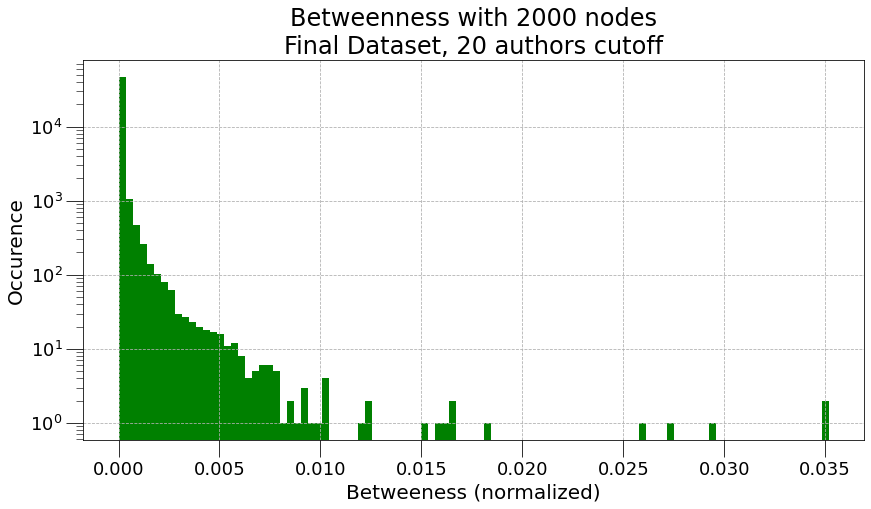

In [34]:
plt.figure(figsize=(14,7))

plt.title("Betweenness with 2000 nodes\nFinal Dataset, 20 authors cutoff", fontsize=24)

plt.hist(list(nodes_n_betweenness.values()), bins=101, color="green")

plt.xlabel("Betweenness (normalized)", fontsize=20)
plt.ylabel("Occurence", fontsize=20)
plt.tick_params(labelsize=18,axis="both",size=17)
plt.tick_params(which="minor",axis="both",size=7)

#plt.xscale("log")
plt.yscale("log")
plt.grid(linestyle="--")

plt.savefig("figs/betweenness_n2000_from_realdata.pdf",format="pdf",bbox_inches="tight")
plt.show()

In [35]:
nodes_n_betweenness2 = nx.betweenness_centrality(sample_graph)

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(14,7))

plt.title("Betweenness with all nodes\nFinal Dataset, 20 authors cutoff", fontsize=24)

plt.hist(list(nodes_n_betweenness2.values()), bins=101, color="green")

plt.xlabel("Betweeness (normalized)", fontsize=20)
plt.ylabel("Occurence", fontsize=20)
plt.tick_params(labelsize=18,axis="both",size=17)
plt.tick_params(which="minor",axis="both",size=7)

#plt.xscale("log")
plt.yscale("log")
plt.grid(linestyle="--")

plt.savefig("figs/betweenness_from_realdata.pdf",format="pdf",bbox_inches="tight")
plt.show()

In [ ]:
# triangles, quadrangle, penta
# compare it to random

# Animation

In [422]:
#making of the GIF
#what i will do here is an illegal move: burning in paramters that are global ones....

def ANIMATIONE_1(name,path,n,slce,fps0,fig_size,ext="gif"):
    """
    INPUT:
        name: file name of the output gif, STRING
        path: path to the ouput, STRING
        data: for the gif, NUMPY.ARRAY        #not used here 
        n:    length of the gif in secundums, INTEGER
        slce: max number of pics in the gif
        fig_size: figure size for figures,    tuple(INT,INT)
        fps0: frame per second for the gif,  INTEGER
        ext:  name of the extension for the output
    
    """
    title = path+name+'.'+ext                                    #path
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=fig_size)      #figure
    secs = 0                                                        #seconds of the GIF
    max_secs = n #ez n                                              #max sec
    fps = fps0                                                      #FPS ofthe GIF
    #######ANIMATION
    def animation(i):
        pic_title = "Evolving Network" 
        slice_num = i % slce
        
        min_year = np.min(tmp_lnk_lst[:,2])
        max_year = np.max(tmp_lnk_lst[:,2])
        years = np.arange(min_year, max_year+1)
        cur_year = years[i]
        
        x_min,x_max = np.min(np.array(list(pos.values()))[:,0]), np.max(np.array(list(pos.values()))[:,0])
        y_min,y_max = np.min(np.array(list(pos.values()))[:,1]), np.max(np.array(list(pos.values()))[:,1])
        
        #PLOT IT - no title at all!
        fig,ax = plt.subplots(2,1, figsize=(22,24), gridspec_kw={'height_ratios': [11,1]}) 

        #axis zero
        ax[0].set_title("Time Evolving Network \n with 20 authors cutoff", fontsize=34)

        nx.draw_networkx_nodes(sample_graph,
                              pos,
                              nodelist = np.unique(tmp_lnk_lst[:,0:2][(cur_year+1)> tmp_lnk_lst[:,2]].flatten()),
                              node_size=7,
                              alpha=0.7,
                              ax=ax[0]
                              )

        nx.draw_networkx_edges(sample_graph,
                              pos,
                              width=0.5,
                              edgelist=tmp_lnk_lst[:,0:2][(cur_year+1)> tmp_lnk_lst[:,2]],
                              edge_color='r',
                              arrows=False,
                              ax=ax[0]
                              )
        ax[0].set_xlim(x_min*1.1,x_max*1.1)
        ax[0].set_ylim(y_min*1.1,y_max*1.1)
        ax[0].set_axis_off()

        #axis one
        #ax[1].plot([min_year],[0.5], "--ro", )
        #ax[1].plot([cur_year],[0.5], "--ro", )
        ax[1].plot([min_year,cur_year],[0.5,0.5], color="black",marker="o", markersize=24, linewidth=10 )
        ax[1].set_xlim(min_year-0.5, max_year+0.5)
        ax[1].set_ylim(0,1)

        ax[1].annotate('{}'.format(min_year),xy=(min_year,0.75), xytext=(min_year-0.15, 0.75), fontsize=22)
        ax[1].annotate('{}'.format(cur_year),xy=(cur_year,0.75), xytext=(cur_year-0.15, 0.75), fontsize=22)

        ax[1].set_xticks([])
        ax[1].set_yticks([])
        ax[1].set_axis_off()

        fig.tight_layout()
        
        #SAVE THE CURRENT GRAPH
        plt.savefig(path + '_img{:04d}.png'.format(i), dpi = 75)
        image = imageio.imread(path + '_img{:04d}.png'.format(i))
        writer.append_data(image)
        
        #CLEAN THE PYPLOT
        plt.cla()
        plt.close(fig)
        
        #UNLINK
        os.unlink(path + '_img{:04d}.png'.format(i))
        
    with imageio.get_writer(title, fps=fps) as writer:
        for i in range(0,n*fps):
            sys.stdout.write('\r' + str(i+1) + ' / ' + str(n*fps))
            sys.stdout.flush()
            animation(i)
            

In [349]:
#generate the positions of the spiral layout with initial 50 iterations
pos = nx.spring_layout(sample_graph)

9 / 9

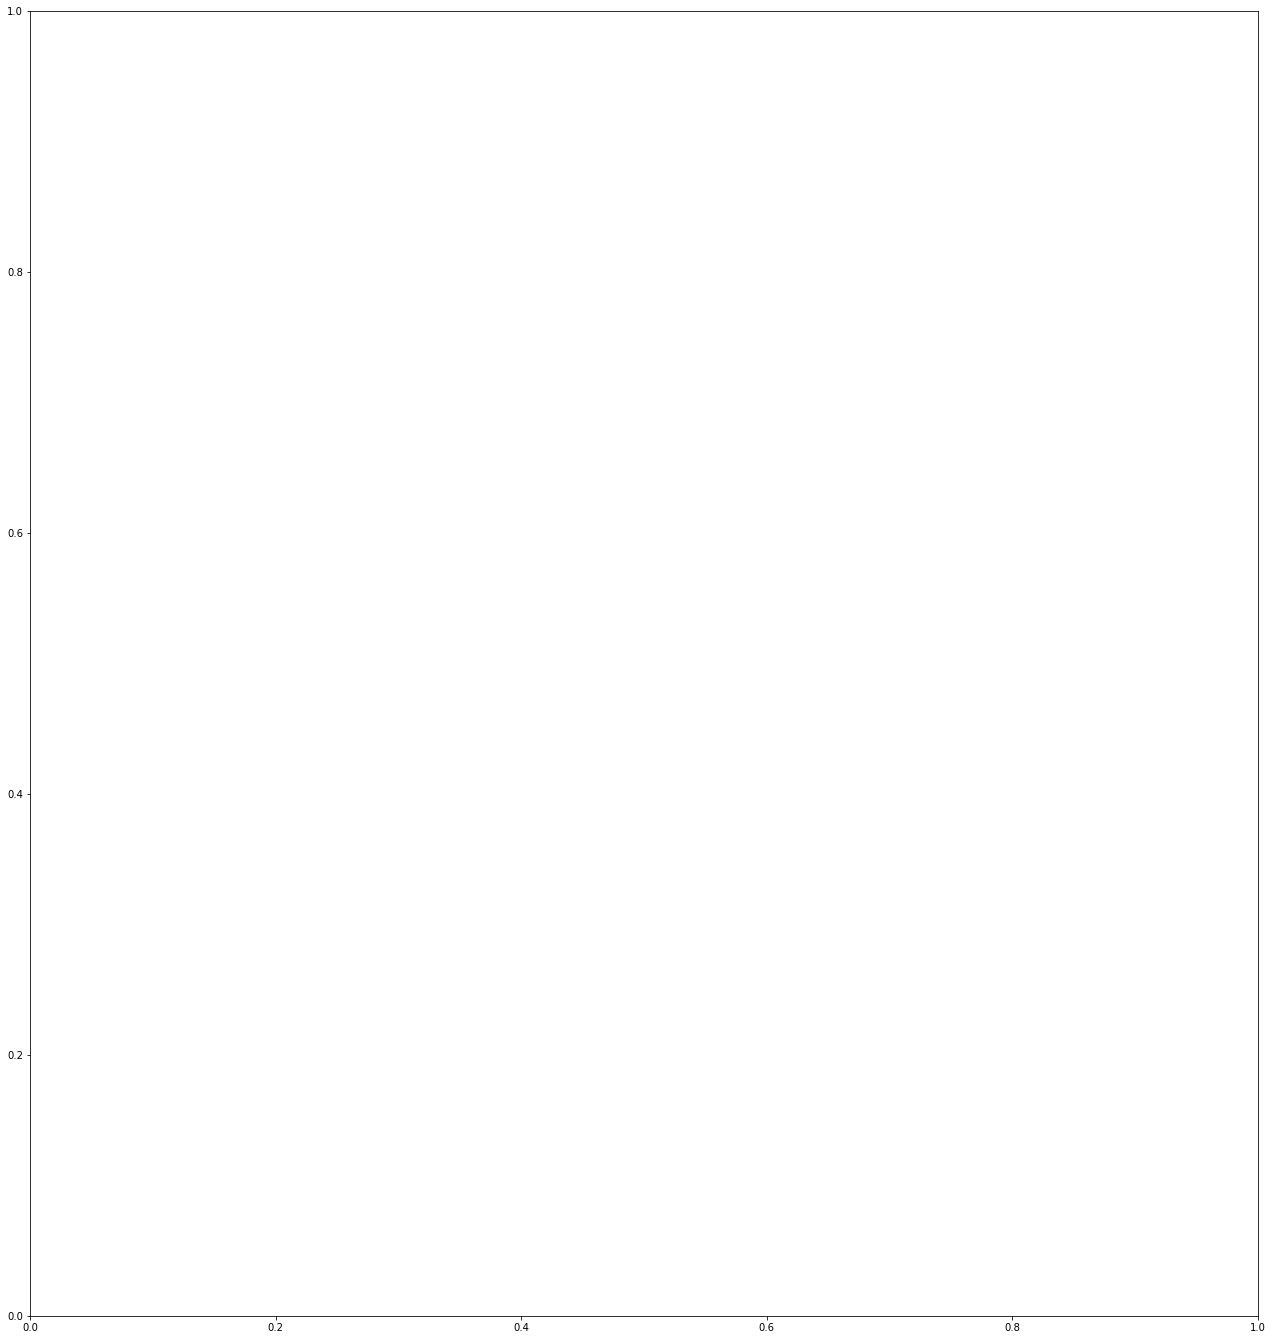

In [423]:
ANIMATIONE_1(name="time_evolving_network",
            path="gifs\\",
            n=len(np.arange(min_year, max_year+1) +1),
            slce=len(np.arange(min_year, max_year+1) +1),
            fps0=1,
            fig_size=(22,24),
            )

In [415]:
x_min,x_max = np.min(np.array(list(pos.values()))[:,0]), np.max(np.array(list(pos.values()))[:,0])
y_min,y_max = np.min(np.array(list(pos.values()))[:,1]), np.max(np.array(list(pos.values()))[:,1])

# Subgraph from the full network

The problem is the size: as it is gargantuan in size, most of the algorithms later on scale with the size on the power of 2 or 3 which means that they don't give results in weeks.

**Solution**: create a subgraph that is sufficient in size that it represents the network, but not too big that the algorithms never give results.


## Subgraph based on multiple sources source

I will choose multiple lecturers from the university to see who is more common!

In [11]:
list_of_csabais = ['CsabaiI.', 'CsabaiIstvan', 'Csabailstvan', 'CsabaiIstván', 'IstvánCsabai', 'ICsabai', 'IstvanCsabai', 'I.Csabai']
list_of_pallas = ['GergelyPalla', 'PallaGergely', 'G.Palla','GPalla']
list_of_vicseks = ['T.Vicsek', 'TVicsek', 'VicsekTamas', 'VicsekTamás', 'TamásVicsek']
list_of_pollners = ['P.Pollner', 'PPollner', 'PeterPollner', 'PollnerPeter', 'PollnerPéter','PéterPollner']
list_of_oroszlanysz = ['OroszlányLászló', 'OroszlányL.', 'LászlóOroszlány', 'LaszloOroszlany', 'LOroszlány', 'LOroszlany']
list_of_stegers = ['J.Stéger', 'JSteger', 'JStéger', 'JózsefStéger']

print()
encodings_of_csabais = np.array([[_UniqueAuthors[i], sample_graph.degree(_UniqueAuthors[i])] for i in list_of_csabais])
#encodings_of_pollners = [[_UniqueAuthors[i], sample_graph.degree(_UniqueAuthors[i])] for i in list_of_pollners]
encodings_of_pallas = np.array([[_UniqueAuthors[i], sample_graph.degree(_UniqueAuthors[i])] for i in list_of_pallas])
encodings_of_vicseks = np.array([[_UniqueAuthors[i], sample_graph.degree(_UniqueAuthors[i])] for i in list_of_vicseks])
encodings_of_oroszlanysz = np.array([[_UniqueAuthors[i], sample_graph.degree(_UniqueAuthors[i])] for i in list_of_oroszlanysz])
encodings_of_stegers = np.array([[_UniqueAuthors[i], sample_graph.degree(_UniqueAuthors[i])] for i in list_of_stegers])
print(encodings_of_csabais[np.argmax(encodings_of_csabais[:,1]),:])
print(encodings_of_pallas[np.argmax(encodings_of_pallas[:,1]),:])
print(encodings_of_vicseks[np.argmax(encodings_of_vicseks[:,1]),:])
print(encodings_of_oroszlanysz[np.argmax(encodings_of_oroszlanysz[:,1]),:])
print(encodings_of_stegers[np.argmax(encodings_of_stegers[:,1]),:])

#combine finals together
final_startpoints = [encodings_of_csabais[np.argmax(encodings_of_csabais[:,1]),:][0],
                    encodings_of_pallas[np.argmax(encodings_of_pallas[:,1]),:][0],
                    encodings_of_vicseks[np.argmax(encodings_of_vicseks[:,1]),:][0],
                    encodings_of_oroszlanysz[np.argmax(encodings_of_oroszlanysz[:,1]),:][0],
                    encodings_of_stegers[np.argmax(encodings_of_stegers[:,1]),:][0]]


[20485   139]
[16484    25]
[43692    70]
[27675    24]
[23653    21]


In [12]:
final_startpoints

[20485, 16484, 43692, 27675, 23653]

In [13]:
list_of_first_neighbors = np.unique([neighbor for sublist in [list(sample_graph.neighbors(i)) for i in final_startpoints] for neighbor in sublist])
list_of_neighbors_neighbors = np.unique([neighbor for sublist in [list(sample_graph.neighbors(i)) for i in list_of_first_neighbors] for neighbor in sublist])
lists = np.unique([lista for sublist in [final_startpoints, list_of_first_neighbors, list_of_neighbors_neighbors] for lista in sublist])

In [14]:
print(len(final_startpoints))
print(len(list_of_first_neighbors))
print(len(list_of_neighbors_neighbors))
print(len(lists))

5
264
1451
1453


In [55]:
single_source_subgraph = nx.Graph()
single_source_subgraph.add_edges_from(sample_graph.edges(lists)) 

degs  = np.array([list(element) for element in list(single_source_subgraph.degree())])

one_degree_nodes = degs[degs[:,1] == 1][:,0]
links = []

#now we have the one degree nodes, let's check if they are connected to each other
for i in one_degree_nodes:
    #i is for the node we look at, get the neighbors
    i_neighbors = list(sample_graph.neighbors(i))
    for j in i_neighbors:
        #get js neighbors, if i is in, save, otherwise pass
        j_neighbors = list(sample_graph.neighbors(j))
        if i in j_neighbors:
            links.append([i,j])

If I have these nodes as edges and look at their neighbors neighbors edges, its going to introduce new edges which are not coming from the neighbors neighbors choosing. I ave to check how this behaves and see how the erros with it can be avoided.

**NOTE**: it seems like there is no actual way to see to get the edge that has defined start and end node, it only gives back starters from the edge view. 

**TRICK**:

1. let's save this graph's edge list
2. let's see if we have degree one nodes
3. go through these nodes and check the full graph if these are connected to each other
4. save any existincing pairs
5. add the to the graph

In [12]:
# i can cut the full linklist, create the graph, look for my specific nodes and their neighbours and proceed to the next step
first_year = min(tmp_lnk_lst[:,2])
last_year = max(tmp_lnk_lst[:,2])
years = np.arange(first_year, last_year+1) + 1 


In [ ]:
years_links = []
print("Starting for {} to {}".format(first_year, last_year))

for i in years:
    this_year_links = []
    temp_list = tmp_lnk_lst[:,:2][i > tmp_lnk_lst[:,2] ]
    print(len(temp_list))
    
    #get the graph object
    stage_graph = nx.Graph()
    stage_graph.add_edges_from(temp_list)
    
    #go through nodes, see if their are neighbors
    for j in list(single_source_subgraph.nodes):
        try:
            j_neighbors_st = list(stage_graph.neighbors(j))
            j_neighbors_simp = list(single_source_subgraph.neighbors(j))
            for k in j_neighbors_simp:
                if k in j_neighbors_st:
                    this_year_links.append([j,k])
        except:
            pass
    #if we gone through all
    years_links.append(this_year_links)

In [69]:
years

array([2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023], dtype=int64)

In [68]:
for i in range(len(years_links)):
    with open("partial_results/subgraph_states/subgraph_states_{}.txt".format(i+1), "wb") as f:
        np.savetxt(f, years_links[i], fmt='%d')

We find every link twice this way, which increases motif finding calculation too much, but leaving the one degree nodes in there makes it look pretty strange. But greedy modularity found it out that joining those together with the center of the star shape, they make the same community. But the greedy modularity is base on community links to.... I guess I am not gonna change it.

In [34]:
len(sample_graph.nodes)

48931

In [ ]:
#saving the edges are sufficient
with open("partial_results/multi_sources_undirected_linklist.txt", "wb") as f:
    np.savetxt(f, np.array([list(edge) for edge in single_source_subgraph.edges]), fmt='%d')

### Source Base Subgraph Representation

In [99]:
#generate the positions of the spiral layout with initial 50 iterations
pos_simple = nx.spring_layout(single_source_subgraph)

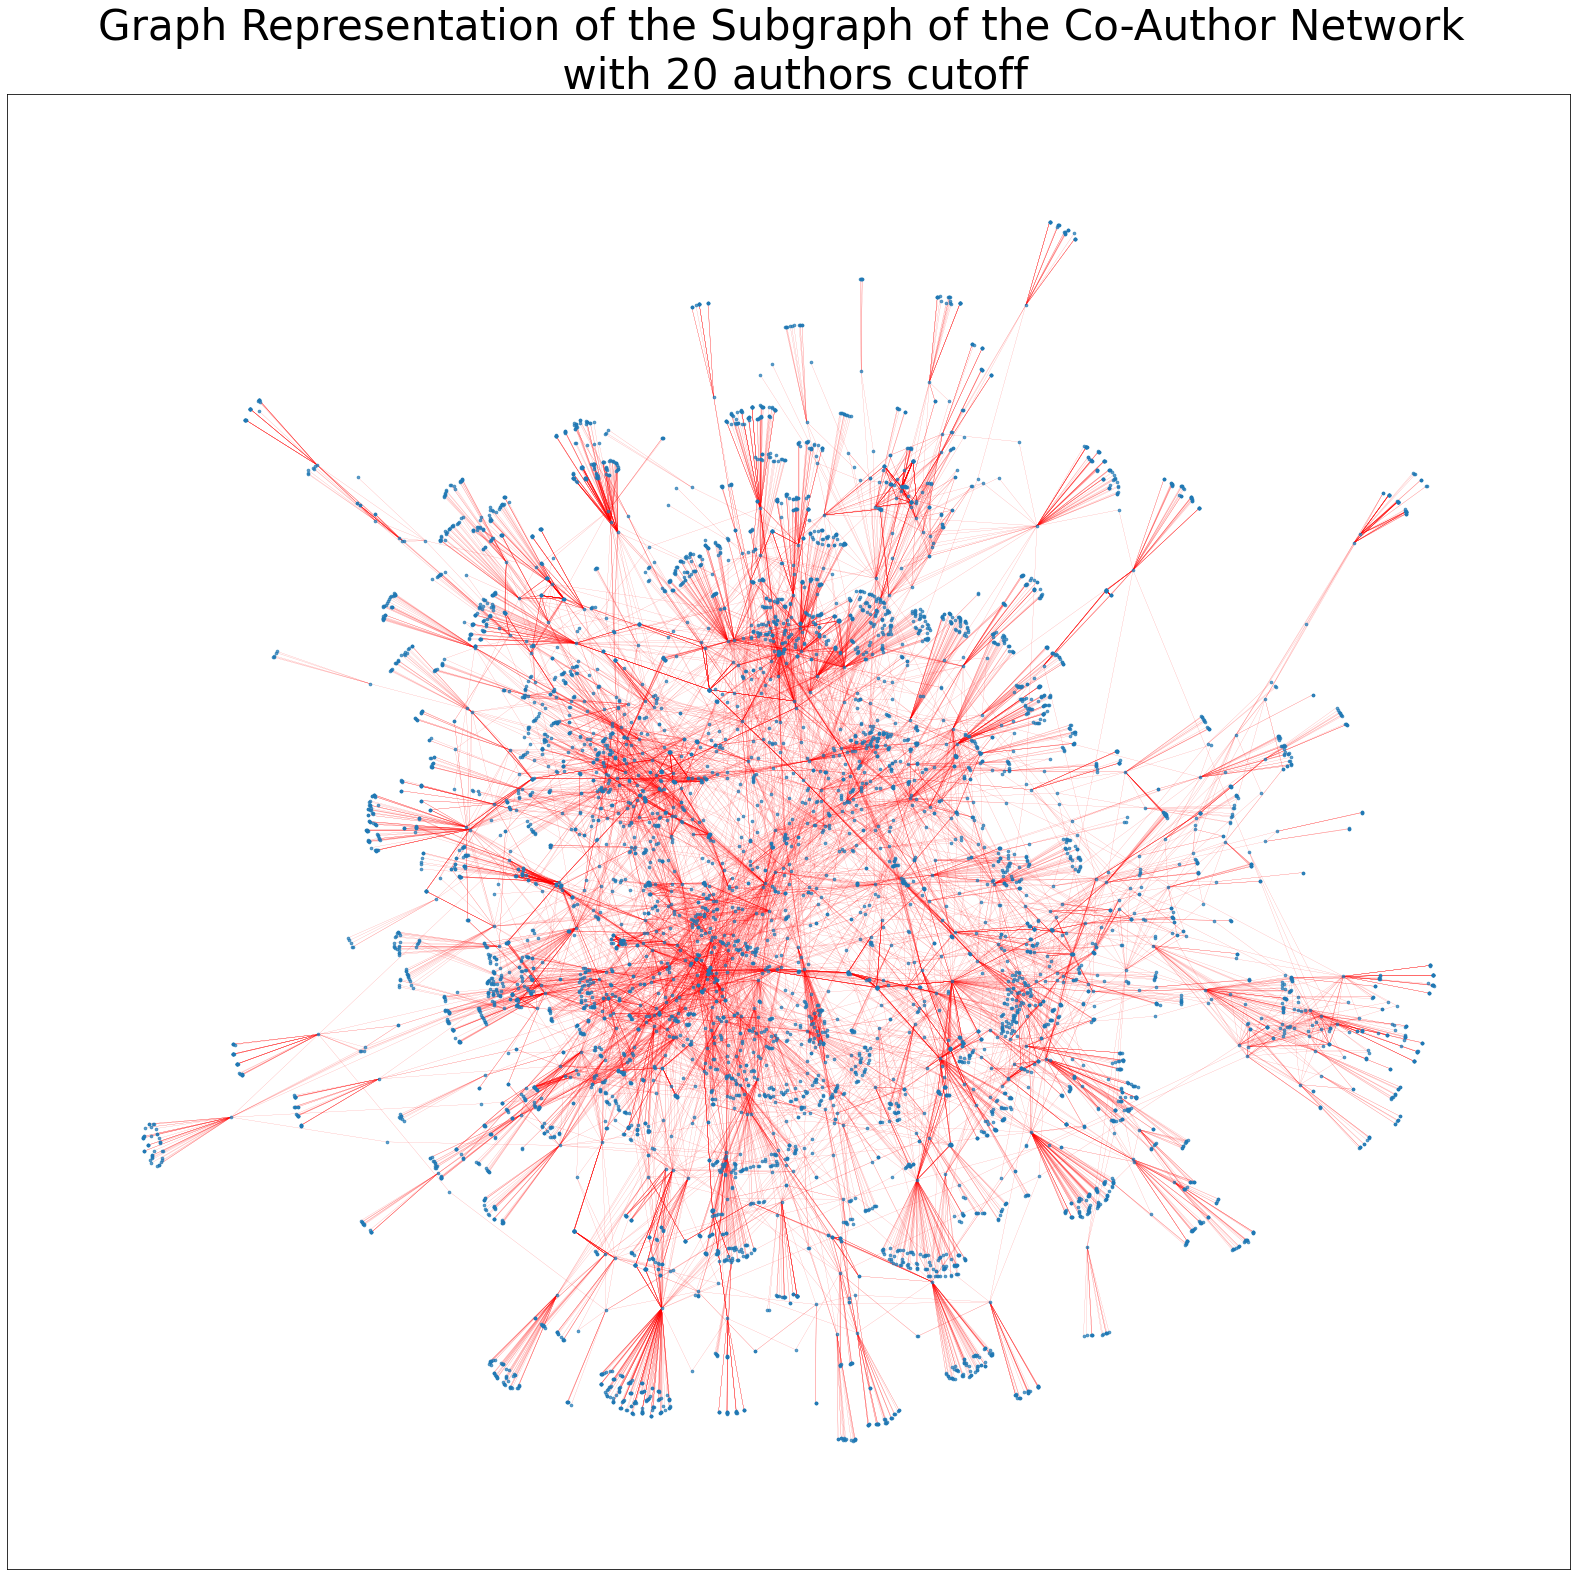

In [100]:
#get the figure
fig = plt.figure(figsize=(22,22))

plt.title("Graph Representation of the Subgraph of the Co-Author Network \n with 20 authors cutoff", fontsize=42)



nx.draw_networkx_nodes(single_source_subgraph,
                      pos_simple,
                      nodelist = np.array(single_source_subgraph.nodes),
                      node_size=7,
                      alpha=0.7
                      )

nx.draw_networkx_edges(single_source_subgraph,
                      pos_simple,
                      width=0.1,
                      edgelist=np.array(single_source_subgraph.edges),
                      edge_color='r',
                      arrows=False)

fig.tight_layout()

plt.savefig("figs/networkx_author_network_from_single_source.pdf", format="pdf", bbox_inches="tight")

#needs some modifications, but starts to look acceptable

plt.show()

# PageRank

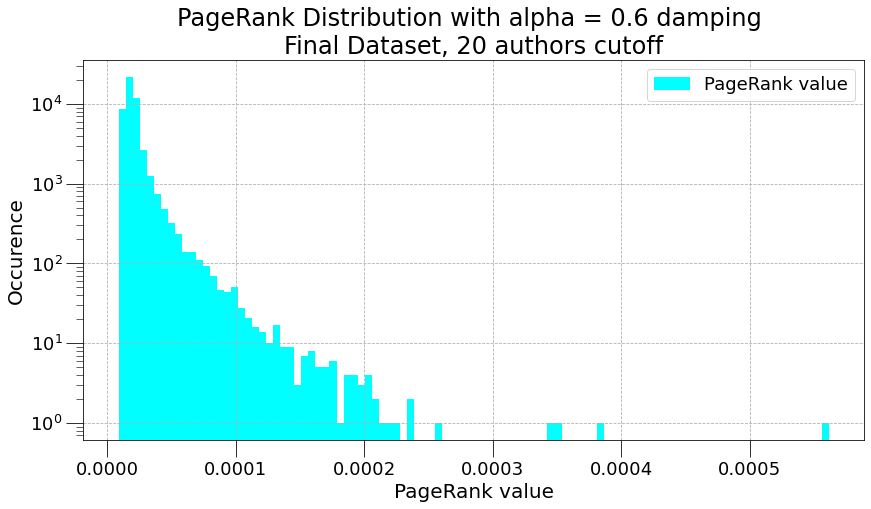

In [46]:
pr = nx.pagerank(sample_graph, alpha=0.6)

plt.figure(figsize=(14,7))

plt.title("PageRank Distribution with alpha = 0.6 damping \nFinal Dataset, 20 authors cutoff", fontsize=24)

plt.hist(list(pr.values()), bins=101, color="cyan", label="PageRank value")

plt.xlabel("PageRank value", fontsize=20)
plt.ylabel("Occurence", fontsize=20)
plt.tick_params(labelsize=18,axis="both",size=17)
plt.tick_params(which="minor",axis="both",size=7)

#plt.xscale("log")
plt.yscale("log")
plt.grid(linestyle="--")
plt.legend(loc="best", fontsize=18)

plt.savefig("figs/pagerank_0_6_from_realdata.pdf",format="pdf",bbox_inches="tight")
plt.show()

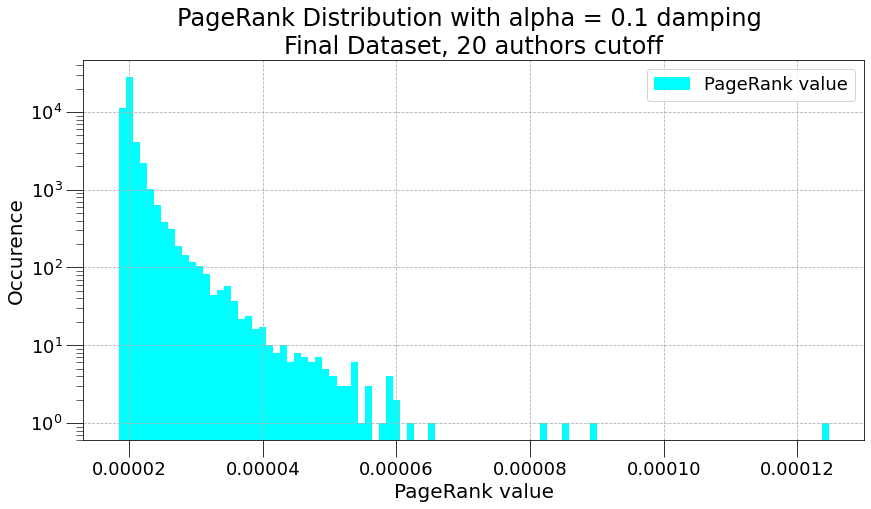

In [47]:
pr = nx.pagerank(sample_graph, alpha=0.1)

plt.figure(figsize=(14,7))

plt.title("PageRank Distribution with alpha = 0.1 damping \nFinal Dataset, 20 authors cutoff", fontsize=24)

plt.hist(list(pr.values()), bins=101, color="cyan", label="PageRank value")

plt.xlabel("PageRank value", fontsize=20)
plt.ylabel("Occurence", fontsize=20)
plt.tick_params(labelsize=18,axis="both",size=17)
plt.tick_params(which="minor",axis="both",size=7)

#plt.xscale("log")
plt.yscale("log")
plt.grid(linestyle="--")
plt.legend(loc="best", fontsize=18)

plt.savefig("figs/pagerank_0_1_from_realdata.pdf",format="pdf",bbox_inches="tight")
plt.show()

# Motifs

https://gist.github.com/tpoisot/8582648

The motifs I am looking for are the following:

1. Open-Triangle (3 nodes)
2. Closed-Triangle (3 nodes)
3. Star (4 nodes)
4. Box (4 nodes)
5. Semi-Clique (4 nodes)
6. Clique (4 nodes)

In [88]:
m_o = ["O-triangle", "Cl-triangle", "Star", "Box", "S-Clique", "Clique"]

In [110]:
#let's generate same example networks
#one is random
n = 15
m = 17
seed = 726
G_r = nx.gnm_random_graph(n,m,seed=seed)

#one artificial
arti_links = np.array(list(zip(np.zeros((8), dtype=np.uint8), np.arange(1,9))))
arti_links = np.append(arti_links, np.array(list(zip(np.ones((8)*2, dtype=np.uint8), np.arange(1,9)+10))),axis=0)
arti_links = np.append(arti_links,[[2,4]], axis=0)
G_a = nx.Graph()
G_a.add_edges_from(arti_links)


len(G_r.edges), len(G_a.edges)

(17, 17)

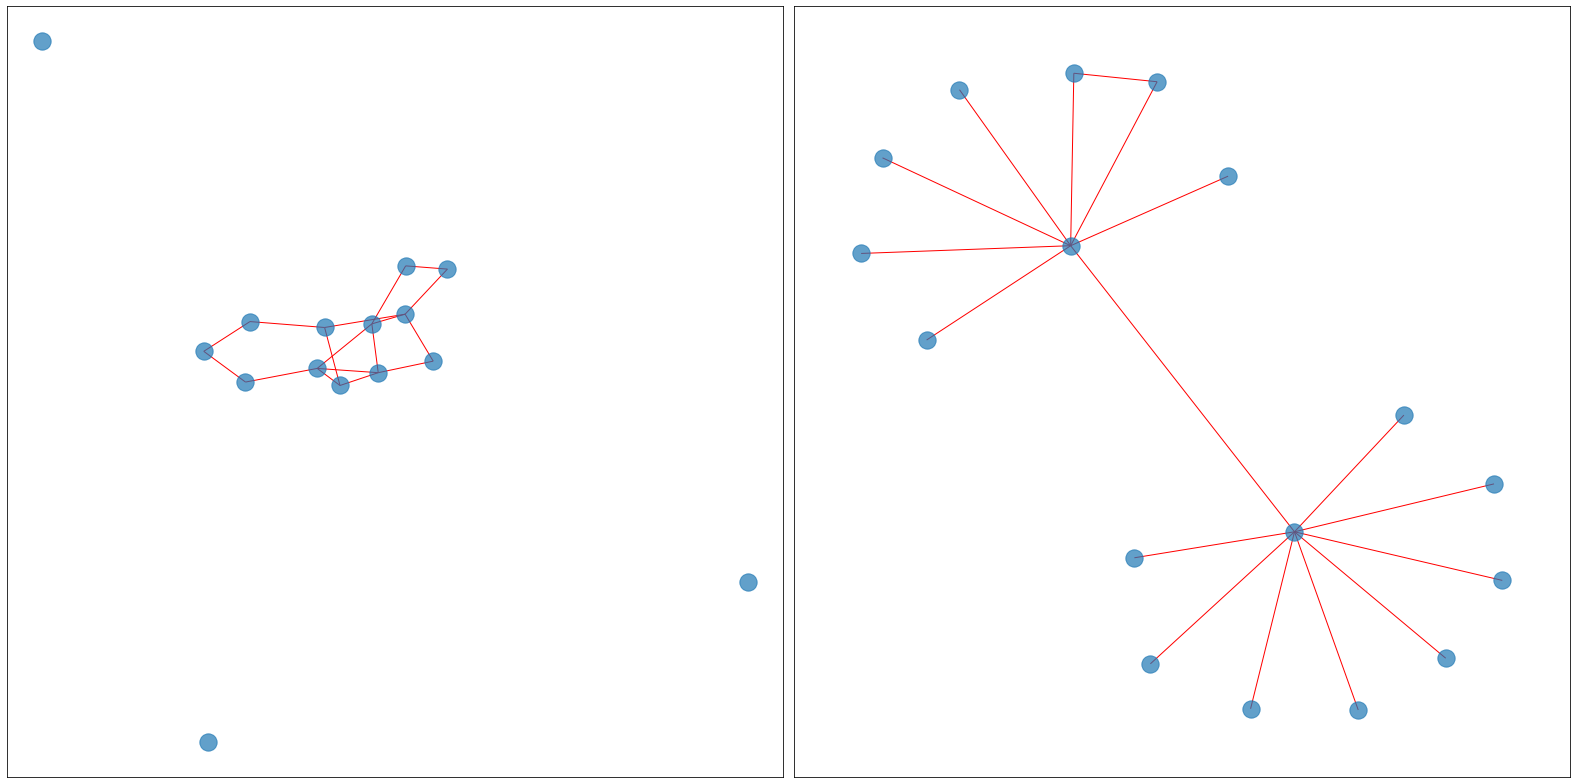

In [111]:
#let's draw them!
pos_r = nx.spring_layout(G_r)
pos_a = nx.spring_layout(G_a)


fig,ax = plt.subplots(nrows = 1, ncols=2, figsize=(22,11))

ax = ax.flatten()

nx.draw_networkx_nodes(G_r, pos_r, nodelist = np.array(G_r.nodes), node_size=300,alpha=0.7, ax= ax[0])

nx.draw_networkx_edges(G_r, pos_r, width=1, edgelist=G_r.edges, edge_color='r', arrows=False, ax = ax[0])

nx.draw_networkx_nodes(G_a, pos_a, nodelist = np.array(G_a.nodes), node_size=300, alpha=0.7, ax=ax[1])

nx.draw_networkx_edges(G_a, pos_a, width=1, edgelist=G_a.edges, edge_color='r', arrows=False, ax=ax[1])

fig.tight_layout()

plt.show()

**Now it can be tested! We just have to compare it to a random graph for reference**

https://www.researchgate.net/figure/All-3-node-4-node-and-5-node-connected-networks-graphlets-ordered-within-groups-from_fig1_8426062

## Networkx motif finding

In [121]:
def generateMotifs():
    motifs = [];
    #3 nodes (2)
    motifs.append(['O-triangle',nx.Graph()]); motifs.append(['Cl-triangle',nx.Graph()])

    motifs[0][1].add_edges_from([[0,1], [1,2]]);        #open triangle
    motifs[1][1].add_edges_from([[0,1], [1,2], [2,0]]); #closed triangle
    #4 nodes (6)
    motifs.append(['star', nx.Graph()]);
    #motifs.append(['chain', nx.Graph()]); 
    #motifs.append(['winged', nx.Graph()]);
    motifs.append(['box', nx.Graph()]);
    motifs.append(['s-clique', nx.Graph()]);
    motifs.append(['clique', nx.Graph()]);

    motifs[2][1].add_edges_from([[0,1], [0,2], [0,3]]);                      #star
    #motifs[3][1].add_edges_from([[0,1], [1,2], [2,3]]);                      #chain
    #motifs[4][1].add_edges_from([[0,1], [0,2], [0,3], [2,3]]);               #triangle with one wing
    motifs[3][1].add_edges_from([[0,1], [1,2], [2,3], [3,0]]);               #box
    motifs[4][1].add_edges_from([[0,1], [1,2], [2,3], [3,0], [0,2]]);        #semi-clique
    motifs[5][1].add_edges_from([[0,1], [1,2], [2,3], [3,0], [0,2], [1,3]]); #clique

    """
    #5 nodes (21)
    motifs.append(['M501', nx.Graph()]); motifs.append(['M502', nx.Graph()]); motifs.append(['M503', nx.Graph()])
    motifs.append(['M504', nx.Graph()]); motifs.append(['M505', nx.Graph()]); motifs.append(['M506', nx.Graph()])
    motifs.append(['M507', nx.Graph()]); motifs.append(['M508', nx.Graph()]); motifs.append(['M509', nx.Graph()])
    motifs.append(['M510', nx.Graph()]); motifs.append(['M511', nx.Graph()]); motifs.append(['M512', nx.Graph()])
    motifs.append(['M513', nx.Graph()]); motifs.append(['M514', nx.Graph()]); motifs.append(['M515', nx.Graph()])
    motifs.append(['M516', nx.Graph()]); motifs.append(['M517', nx.Graph()]); motifs.append(['M518', nx.Graph()])
    motifs.append(['M519', nx.Graph()]); motifs.append(['M520', nx.Graph()]); motifs.append(['M521', nx.Graph()])

    motifs[8][1].add_edges_from([[0,1], [1,2], [2,3], [3,4]]);   # chain
    motifs[9][1].add_edges_from([[0,1], [1,2], [2,3], [2,4]]);   # split
    motifs[10][1].add_edges_from([[0,1], [0,2], [0,3], [0,4]]);  # cross
    motifs[11][1].add_edges_from([[0,1], [0,2], [1,2], [1,3], [2,4]]); # triangle with 2 wings
    motifs[12][1].add_edges_from([[0,1], [0,2], [1,2], [0,3], [3,4]]); # triangle with 1 long chain
    motifs[13][1].add_edges_from([[0,1], [0,2], [1,2], [0,3], [0,4]]); # triangle with one node 2 wings
    motifs[14][1].add_edges_from([[0,1], [1,2], [2,3], [3,4], [4,0]]); # penta-box
    motifs[15][1].add_edges_from([[0,1], [1,2], [2,3], [3,0], [4,0]]); # box with chain
    motifs[16][1].add_edges_from([[0,1], [1,2], [2,3], [3,0], [4,0], [0,2]]);  # verti crossed semi clique 1 wing
    motifs[17][1].add_edges_from([[0,1], [1,2], [2,0], [0,3], [3,4], [4,0]]);  # joiend 2 triangle
    motifs[18][1].add_edges_from([[0,1], [1,2], [2,3], [3,0], [4,0], [1,3]]);  # horti crossed semi clique 1 wing
    motifs[19][1].add_edges_from([[0,1], [1,2], [2,3], [3,0], [0,4], [4,2]]);  # filled quadrangle
    motifs[20][1].add_edges_from([[0,1], [1,2], [2,3], [3,0], [0,4], [4,1]]);  # house
    motifs[21][1].add_edges_from([[0,1], [1,2], [2,3], [3,0], [0,2], [0,4], [4,2]]);  # strange diamond
    motifs[22][1].add_edges_from([[0,1], [1,2], [2,0], [0,3], [1,3], [2,3], [0,4]]);
    motifs[23][1].add_edges_from([[0,1], [1,2], [2,0], [0,3], [1,3], [0,4], [3,4]]); # trapeze
    motifs[24][1].add_edges_from([[0,1], [1,2], [2,0], [0,3], [1,3], [3,4], [2,4]]);
    motifs[25][1].add_edges_from([[0,1], [1,2], [2,3], [3,0], [0,2], [0,4], [4,2], [1,4]]);
    motifs[26][1].add_edges_from([[0,1], [1,2], [2,3], [3,0], [0,4], [1,4], [2,4], [3,4]]);
    motifs[28][1].add_edges_from([[0,1], [0,2], [0,3], [0,4], [1,2], [1,3], [1,4], [2,3], [2,4]]); #almost full penta
    motifs[28][1].add_edges_from([[0,1], [0,2], [0,3], [0,4], [1,2], [1,3], [1,4], [2,3], [2,4], [3,4]]);  #full penta
    """
    
    return motifs

def calcRevelancy(graph,motifs_gen=generateMotifs, seed=726, random_num=5, reroll=0.3):
    """
    Gives the revelanvy of given motifs (Z SCORE)
    (m_obs - m_rand_avg) / (sigma_rand)
    
    INPUT:
        graoh: graph object for comparison
        motif_gen: func, generates motifs
        seed= integer for seeding random choosings
        random_num = amount of random networks to be generated
        reroll= float, (0,1], how much percentage of the links should be remade
    OUTPUT:
        motifs_order: name of the motfis, motif_gen gives it
        motifs_match_count: array for motifs found in graph, random generated graph and revelancy
    """
    #generate random graph
    G_a = graph
    #generate random_num random graphs (sufficient for my needs)
    randoms = []
    for i in range(random_num):
        G_random_base = nx.Graph()
        G_random_base.add_edges_from(G_a.edges)
        print("Generating randomized network number {}".format(i))
        randoms.append(nx.double_edge_swap(G_random_base,
                                           nswap=int(reroll*len(list(G_random_base.edges))),
                                           max_tries=200*int(reroll*len(list(G_random_base.edges))),
                                           seed=seed-i))
    
    #containers
    motifs_order0 = []
    motifs_match_count0 = []
    
    motifs = motifs_gen()
    
    #let's have the subgraph matchers
    for i in motifs:
        
        GM_a_i = 0
        GM_r_i = np.zeros((random_num))
        
        cnt_a_i = 0
        
        
        sys.stdout.write("\rAt {}, {}/{}".format(i[0],0,random_num+1))
        sys.stdout.flush()
        
        #get the graph matcher
        GM_a_i = nx.algorithms.isomorphism.GraphMatcher(G_a,i[1])
        #count how many matches it has with iter
        for iso in GM_a_i.subgraph_isomorphisms_iter():
            cnt_a_i+=1
        
        #let's do link randomization from the original network
        for j in range(random_num):
            cnt_r_i = 0
            sys.stdout.write("\rAt {}, {}/{}".format(i[0],j+1,random_num+1))
            sys.stdout.flush()
            GM_r_iso = nx.algorithms.isomorphism.GraphMatcher(randoms[j],i[1])
            #count how many matches it has with iter
            for iso in GM_r_iso.subgraph_isomorphisms_iter():
                cnt_r_i+=1
            GM_r_i[j] = cnt_r_i

        #now we should have the observed network and the random networks random app
        


        motifs_order0.append([i[0]])
        revelancy = 0
        if not (np.var(GM_r_i) == 0):
            revelancy = (cnt_a_i-np.mean(GM_r_i))/(np.var(GM_r_i)**(1/2))

        motifs_match_count0.append([cnt_a_i, np.mean(GM_r_i), revelancy])
    
    print("\nFinished")
    
    return np.array(motifs_order0), np.array(motifs_match_count0)

## IGRAPH motif finding

https://igraph.org/python/api/0.9.8/igraph._igraph.GraphBase.html#count_isomorphic_vf2

In [ ]:
"""
--------------------------------------------------------------------------------------------------
IGRAPH
--------------------------------------------------------------------------------------------------
"""

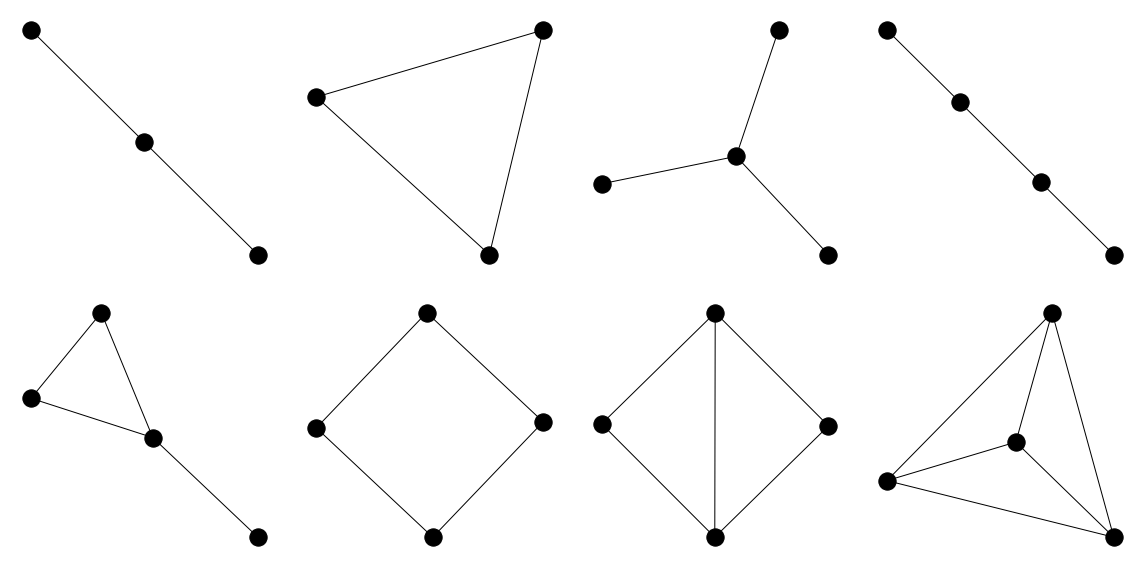

In [219]:
motives = generateMotifs()
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16,8))

axes = axes.flatten()

for i in range(len(axes)):
    pos_m = nx.spring_layout(motives[i][1])
    nx.draw_networkx_nodes(motives[i][1], pos_m, nodelist = np.array(motives[i][1].nodes),node_color='black', node_size=300,alpha=1.0, ax= axes[i])
    nx.draw_networkx_edges(motives[i][1], pos_m, width=1, edgelist=motives[i][1].edges, edge_color='black', arrows=False, ax = axes[i])
    axes[i].axis('off')
    
plt.savefig("figs/motifs_3_n_4_node.pdf",format="pdf",bbox_inches="tight")
fig.tight_layout()
plt.show()

In [123]:
with open("partial_results/second_largest_component.txt", "rb") as f:
    com_link_list = np.loadtxt(f, delimiter=" ")
    
second_compx = nx.Graph()
second_compx.add_edges_from(com_link_list)

second_compi = igraph.Graph()
second_compi = second_compi.Read_Edgelist("partial_results/second_largest_component.txt")


len(second_compx.edges), len(second_compx.nodes)

(150, 38)

In [19]:
com_link_list

array([[ 1792,  1186],
       [ 1792,   655],
       [ 1792, 18396],
       [ 1792, 33934],
       [ 1792, 10019],
       [ 1792, 38647],
       [ 1792, 11851],
       [ 1792, 12181],
       [ 1792, 40475],
       [27265, 18396],
       [27265,  1186],
       [27265, 30707],
       [27265, 12181],
       [27265, 33934],
       [27265,   655],
       [27265,  5558],
       [27265, 15159],
       [27265, 12004],
       [50951,  1186],
       [50951, 12444],
       [50951, 35776],
       [50951, 10197],
       [50951, 50251],
       [  651,  1186],
       [  651, 24668],
       [  651, 51003],
       [33934,  1186],
       [33934,   655],
       [33934, 18396],
       [33934, 11851],
       [33934, 19550],
       [33934, 12004],
       [33934, 12181],
       [33934, 40475],
       [33934, 30707],
       [33934,  5558],
       [33934, 15159],
       [33934, 10019],
       [33934, 38647],
       [  655,  1186],
       [  655, 18396],
       [  655, 11851],
       [  655, 19550],
       [  6

In [124]:
m_o, m_m_c = calcRevelancy(second_compx)

Generating randomized network number 0
Generating randomized network number 1
Generating randomized network number 2
Generating randomized network number 3
Generating randomized network number 4
At clique, 5/6/65/6
Finished


In [125]:
m_o, m_m_c

(array([['O-triangle'],
        ['Cl-triangle'],
        ['star'],
        ['box'],
        ['s-clique'],
        ['clique']], dtype='<U11'),
 array([[ 1.52400000e+03,  2.26800000e+03, -1.85260434e+01],
        [ 2.02800000e+03,  1.28400000e+03,  1.85260434e+01],
        [ 2.73240000e+04,  3.25584000e+04, -1.02172220e+01],
        [ 0.00000000e+00,  1.17120000e+03, -6.98697247e+00],
        [ 2.02000000e+03,  3.44240000e+03, -2.04273379e+01],
        [ 1.29360000e+04,  3.39360000e+03,  2.10185104e+01]]))

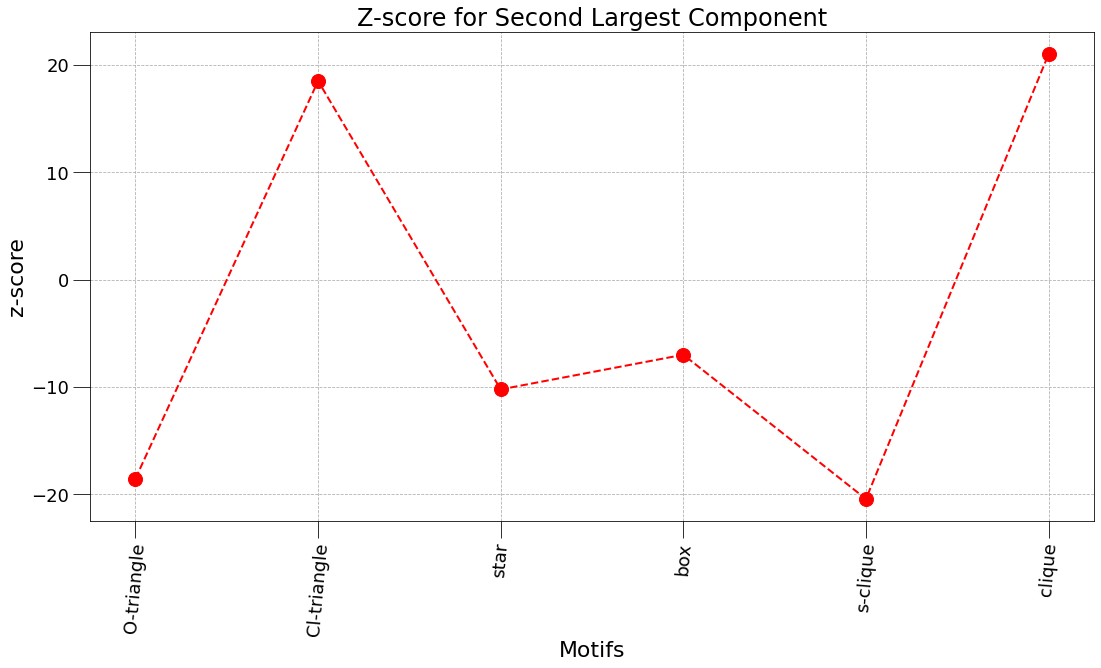

In [126]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(18,9))

ax.set_title("Z-score for Second Largest Component", fontsize=24)

ax.plot(m_m_c[:,2], "--ro",
        markersize=14,
        linewidth=2)
ax.set_xticks(np.arange(len(m_o)))
ax.set_xticklabels(m_o.flatten(), rotation=85)
ax.tick_params(labelsize=18,axis="both",size=17)
ax.tick_params(which="minor",axis="both",size=7)

ax.set_xlabel("Motifs", fontsize=22)
ax.set_ylabel("z-score", fontsize=22)

ax.grid(linestyle="--")

plt.savefig("figs/z_score_second_largest_component.pdf",format="pdf",bbox_inches="tight")

plt.show()

## Real network motif finding

This calculation is moved to tests/motif_search.py. This python file is for calculating motifs in a given graph, while it has multiprocessing in it.

Further speedups:


igraph itself:
https://igraph.org/python/api/0.9.8/igraph._igraph.GraphBase.html#isomorphic_vf2

The base is the vf2 algorithm, I need to test how fast this is compared to networkx and check how to create graphs in igraph to make an analogous calculation.


The best speedup is to decrease the network in size, the usage of subgraph, which is still a good representation of the network.

In [10]:
#empty or removed
os.system("python tests/motif_searcher.py")

0

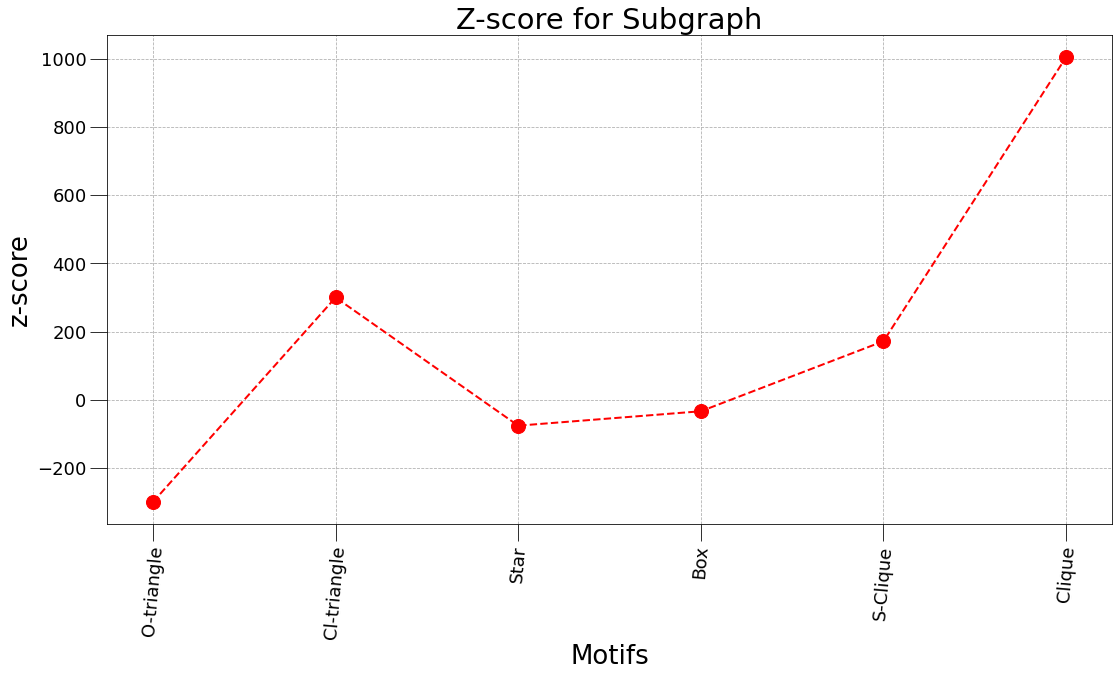

In [12]:
#load in info

z_score_data = np.load("partial_results/motif_finding_results.npy")

fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(18,9))

ax.set_title("Z-score for Subgraph", fontsize=29)

ax.plot(z_score_data[:,2], "--ro",
        markersize=14,
        linewidth=2)
ax.set_xticks(np.arange(len(m_o)))
ax.set_xticklabels(m_o, rotation=85)
ax.tick_params(labelsize=18,axis="both",size=17)
ax.tick_params(which="minor",axis="both",size=7)

ax.set_xlabel("Motifs", fontsize=26)
ax.set_ylabel("z-score", fontsize=26)

ax.grid(linestyle="--")

plt.savefig("figs/z_score_calculated_from_subgraph.pdf",format="pdf",bbox_inches="tight")

plt.show()

## Z-score in time-evolution

In [84]:
#create infofile
info_file =  open("../SciMod/partial_results/subgraph_motifs/test_file.txt", "w")
info_file.write("# runtime, nodes, degrees\n")
info_file.close()



#let's do it for each file
inpath = [("../SciMod/partial_results/subgraph_states/"+i) for i in os.listdir("../SciMod/partial_results/subgraph_states/")]
outpath = ["../SciMod/partial_results/subgraph_motifs/motifs_in_{}.npy".format(i+1) for i in range(len(years))]

for i in range(len(inpath)):
    print("python tests/motif_searcher.py " + inpath[i] + " " + outpath[i])
    os.system("python tests/motif_searcher.py " + inpath[i] + " " + outpath[i])

python tests/motif_searcher.py ../SciMod/partial_results/subgraph_states/subgraph_states_1.txt ../SciMod/partial_results/subgraph_motifs/motifs_in_1.npy
python tests/motif_searcher.py ../SciMod/partial_results/subgraph_states/subgraph_states_2.txt ../SciMod/partial_results/subgraph_motifs/motifs_in_2.npy
python tests/motif_searcher.py ../SciMod/partial_results/subgraph_states/subgraph_states_3.txt ../SciMod/partial_results/subgraph_motifs/motifs_in_3.npy
python tests/motif_searcher.py ../SciMod/partial_results/subgraph_states/subgraph_states_4.txt ../SciMod/partial_results/subgraph_motifs/motifs_in_4.npy
python tests/motif_searcher.py ../SciMod/partial_results/subgraph_states/subgraph_states_5.txt ../SciMod/partial_results/subgraph_motifs/motifs_in_5.npy
python tests/motif_searcher.py ../SciMod/partial_results/subgraph_states/subgraph_states_6.txt ../SciMod/partial_results/subgraph_motifs/motifs_in_6.npy
python tests/motif_searcher.py ../SciMod/partial_results/subgraph_states/subgraph_

Now that this is done, we can gather the data and see how good are the results.

In [86]:
datas = []
for path in outpath:
    datas.append(np.load(path))

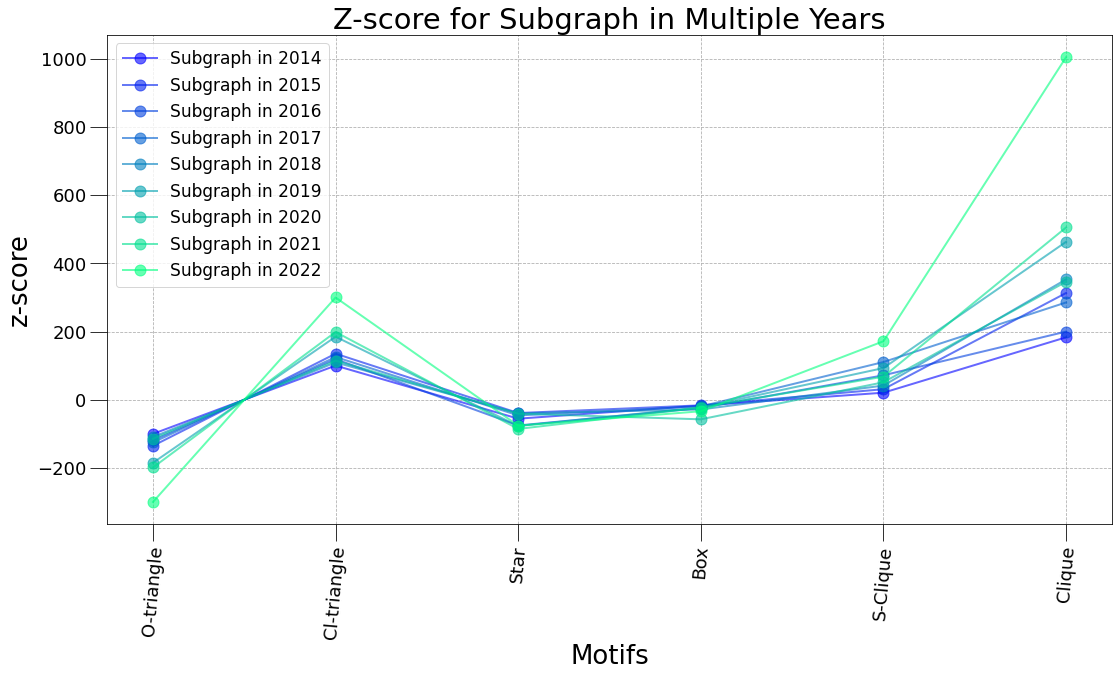

In [101]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(18,9))

ax.set_title("Z-score for Subgraph in Multiple Years", fontsize=29)

colors = plt.cm.winter(np.linspace(0,1,len(datas)))

for i,data in enumerate(datas):
    ax.plot(data[:,2],
            markersize=11,
            linewidth=2,
            alpha=0.6,
            color=colors[i],
            marker='o',
            label="Subgraph in {}".format((years-1)[i]))
ax.set_xticks(np.arange(len(m_o)))
ax.set_xticklabels(m_o, rotation=85)
ax.tick_params(labelsize=18,axis="both",size=17)
ax.tick_params(which="minor",axis="both",size=7)

ax.set_xlabel("Motifs", fontsize=26)
ax.set_ylabel("z-score", fontsize=26)

ax.legend(loc='best', fontsize=17)
ax.grid(linestyle="--")

plt.savefig("figs/z_score_from_subgraph_evolution.pdf",format="pdf",bbox_inches="tight")

plt.show()

So it is visible that:

1. The graph has more and more of the higher clustered motifs in it, making it itself a graph with high clustering coefficient.

2. The randomization easily destroys this and favors the less clustered motifs.

# Group Searching

Group searching methods will be here.

https://stackoverflow.com/questions/49064611/how-to-find-different-groups-in-networkx-using-python

https://networkx.org/documentation/stable/reference/algorithms/community.html

**NOTE**: good groupd searching methods to try out:

1. MODULARITY BASED (this is what I started here)
2. INFOMAP
3. DIFFUSIVE  (this is a group, louvain is here)
4. C-FINDER



## Group searching for smaller graphs

The group searching is generally fast and the functions in networkx give back the components by list the nodes in the components as frozen sets. The problem is these group searching methods scale with the network on the pwoer of 2 or 3, so using the giant component is not advised as it takes a long amount of time

In [33]:
with open("partial_results/multi_sources_undirected_linklist.txt", "rb") as f:
    multi_source_edges = np.loadtxt(f, delimiter=" ")
    
single_source_subgraph = nx.Graph()
single_source_subgraph.add_edges_from(multi_source_edges) 

In [94]:
#if I was very mean, I could but this into one line :^)
greedy_list_of_communities = nx_comm.greedy_modularity_communities(single_source_subgraph)
greedy_list_of_communities = [list(lista) for lista in greedy_list_of_communities]
greedy_list_of_communities = [list(zip(greedy_list_of_communities[i], [i for j in range(len(greedy_list_of_communities[i]))])) for i in range(len(greedy_list_of_communities))]
greedy_list_of_communities = [list(element) for sublist in greedy_list_of_communities for element in sublist]
greedy_list_of_communities_dict = dict(greedy_list_of_communities)

## Drawing Each Community

This person created a code that separates communities

https://stackoverflow.com/questions/43541376/how-to-draw-communities-with-networkx

In [108]:
def community_layout(g, partition):
    """
    Compute the layout for a modular graph.


    Arguments:
    ----------
    g -- networkx.Graph or networkx.DiGraph instance
        graph to plot

    partition -- dict mapping int node -> int community
        graph partitions


    Returns:
    --------
    pos -- dict mapping int node -> (float x, float y)
        node positions

    """

    pos_communities = _position_communities(g, partition, scale=8.)

    pos_nodes = _position_nodes(g, partition, scale=0.3)

    # combine positions
    pos = dict()
    for node in g.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node]

    return pos

def _position_communities(g, partition, **kwargs):

    # create a weighted graph, in which each node corresponds to a community,
    # and each edge weight to the number of edges between communities
    between_community_edges = _find_between_community_edges(g, partition)

    communities = set(partition.values())
    hypergraph = nx.Graph()                                   #nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))

    # find layout for communities
    pos_communities = nx.spring_layout(hypergraph, **kwargs)

    # set node positions to position of community
    pos = dict()
    for node, community in partition.items():
        pos[node] = pos_communities[community]

    return pos

def _find_between_community_edges(g, partition):

    edges = dict()

    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]

    return edges

def _position_nodes(g, partition, **kwargs):
    """
    Positions nodes within communities.
    """

    communities = dict()
    for node, community in partition.items():
        try:
            communities[community] += [node]
        except KeyError:
            communities[community] = [node]

    pos = dict()
    for ci, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        pos_subgraph = nx.spring_layout(subgraph, **kwargs)
        pos.update(pos_subgraph)

    return pos

In [106]:
#i have to wrap my structure around is to make it usable
pos_coms = community_layout(g = single_source_subgraph,partition = greedy_list_of_communities_dict)

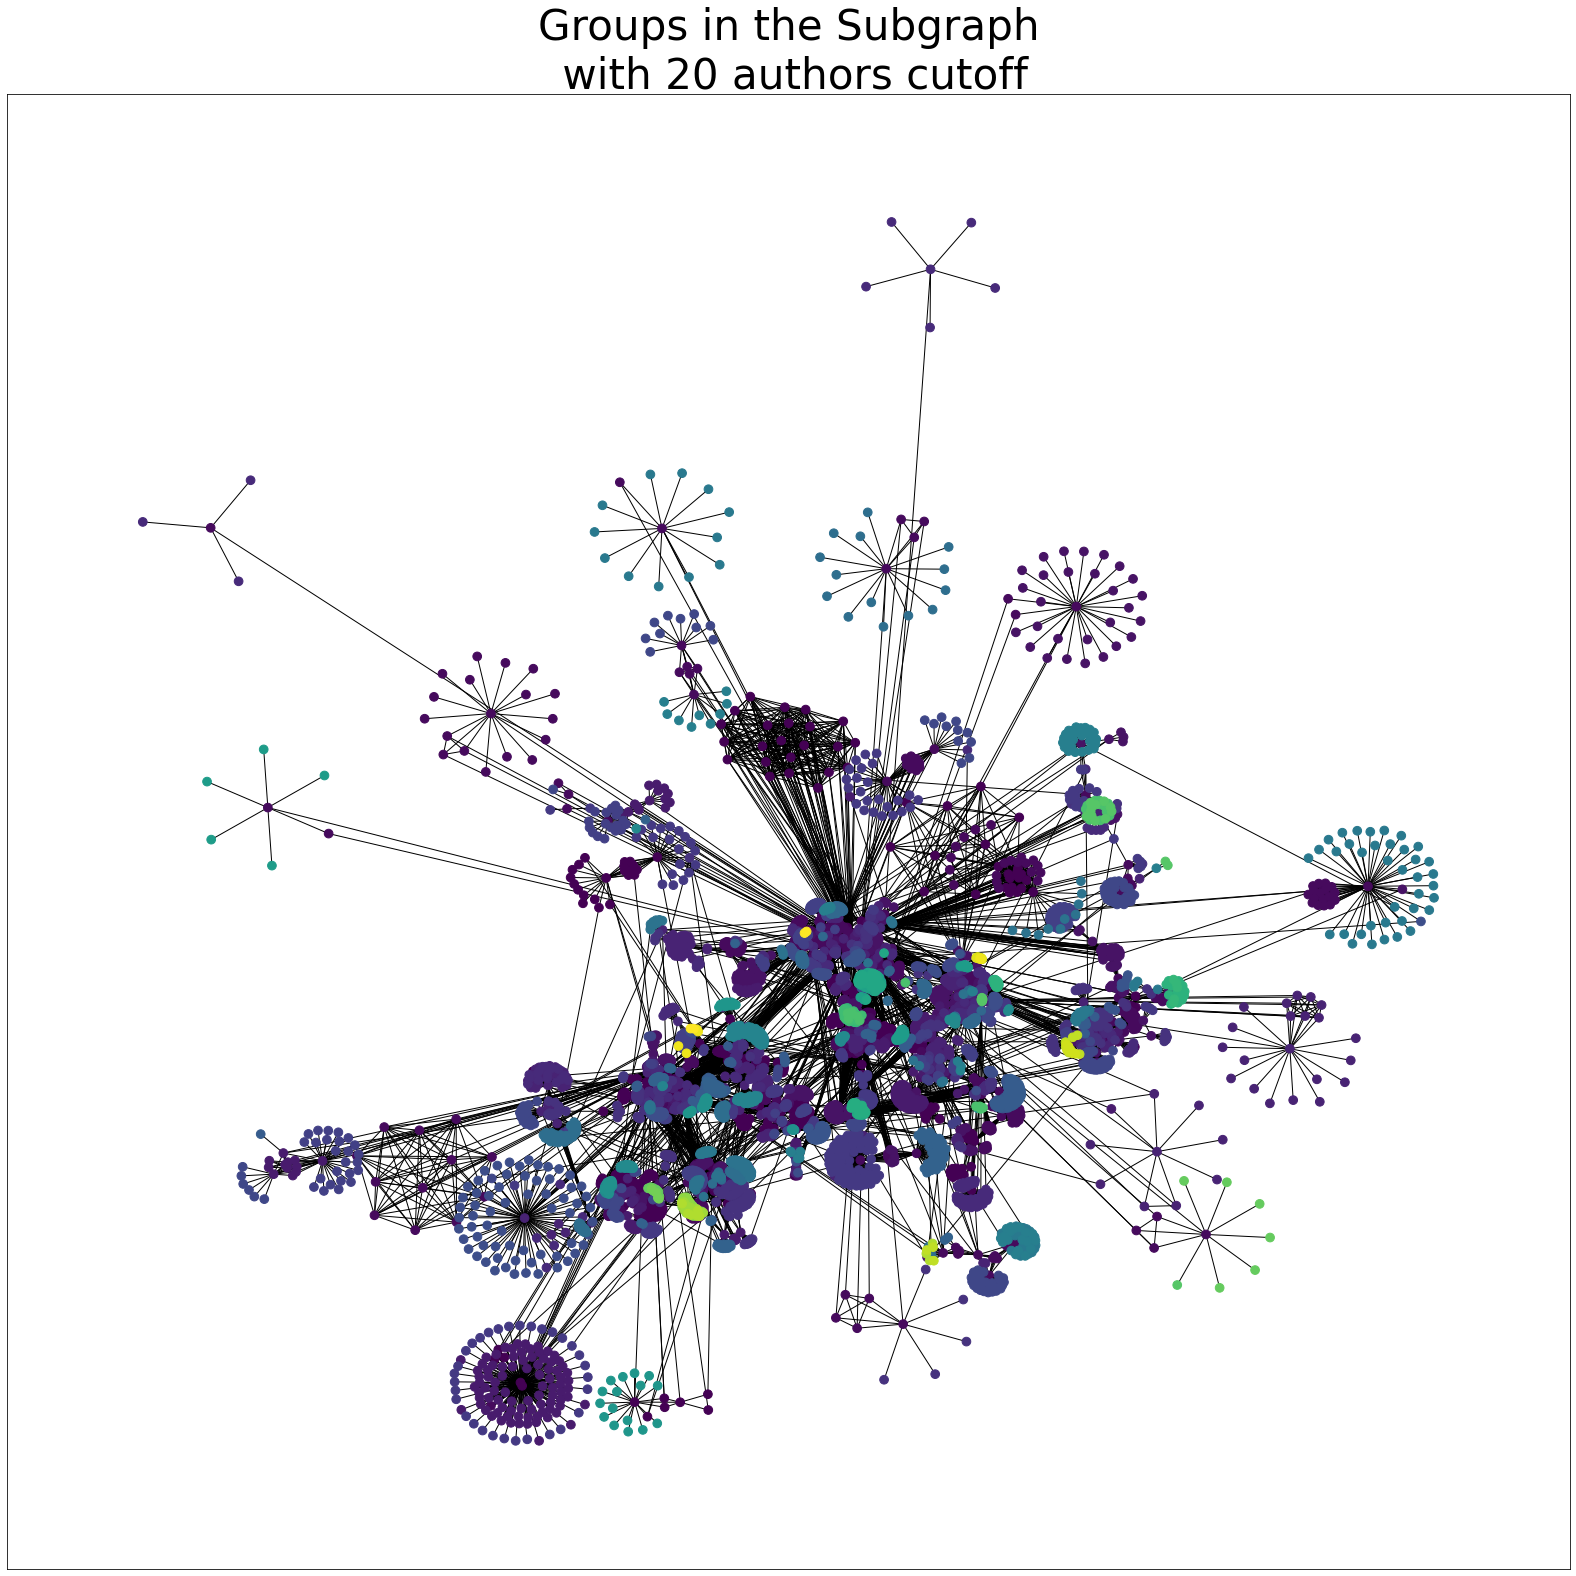

In [120]:
#get the figure
fig = plt.figure(figsize=(22,22))

plt.title("Groups in the Subgraph\n with 20 authors cutoff", fontsize=42)
nx.draw(single_source_subgraph, pos_coms, node_color=list(greedy_list_of_communities_dict.values()), node_size=75)
fig.tight_layout()
plt.axis('on')

plt.savefig("figs/group_searching_greedy_modularity_a.pdf", format="pdf", bbox_inches="tight")

#needs some modifications, but starts to look acceptable

plt.show()

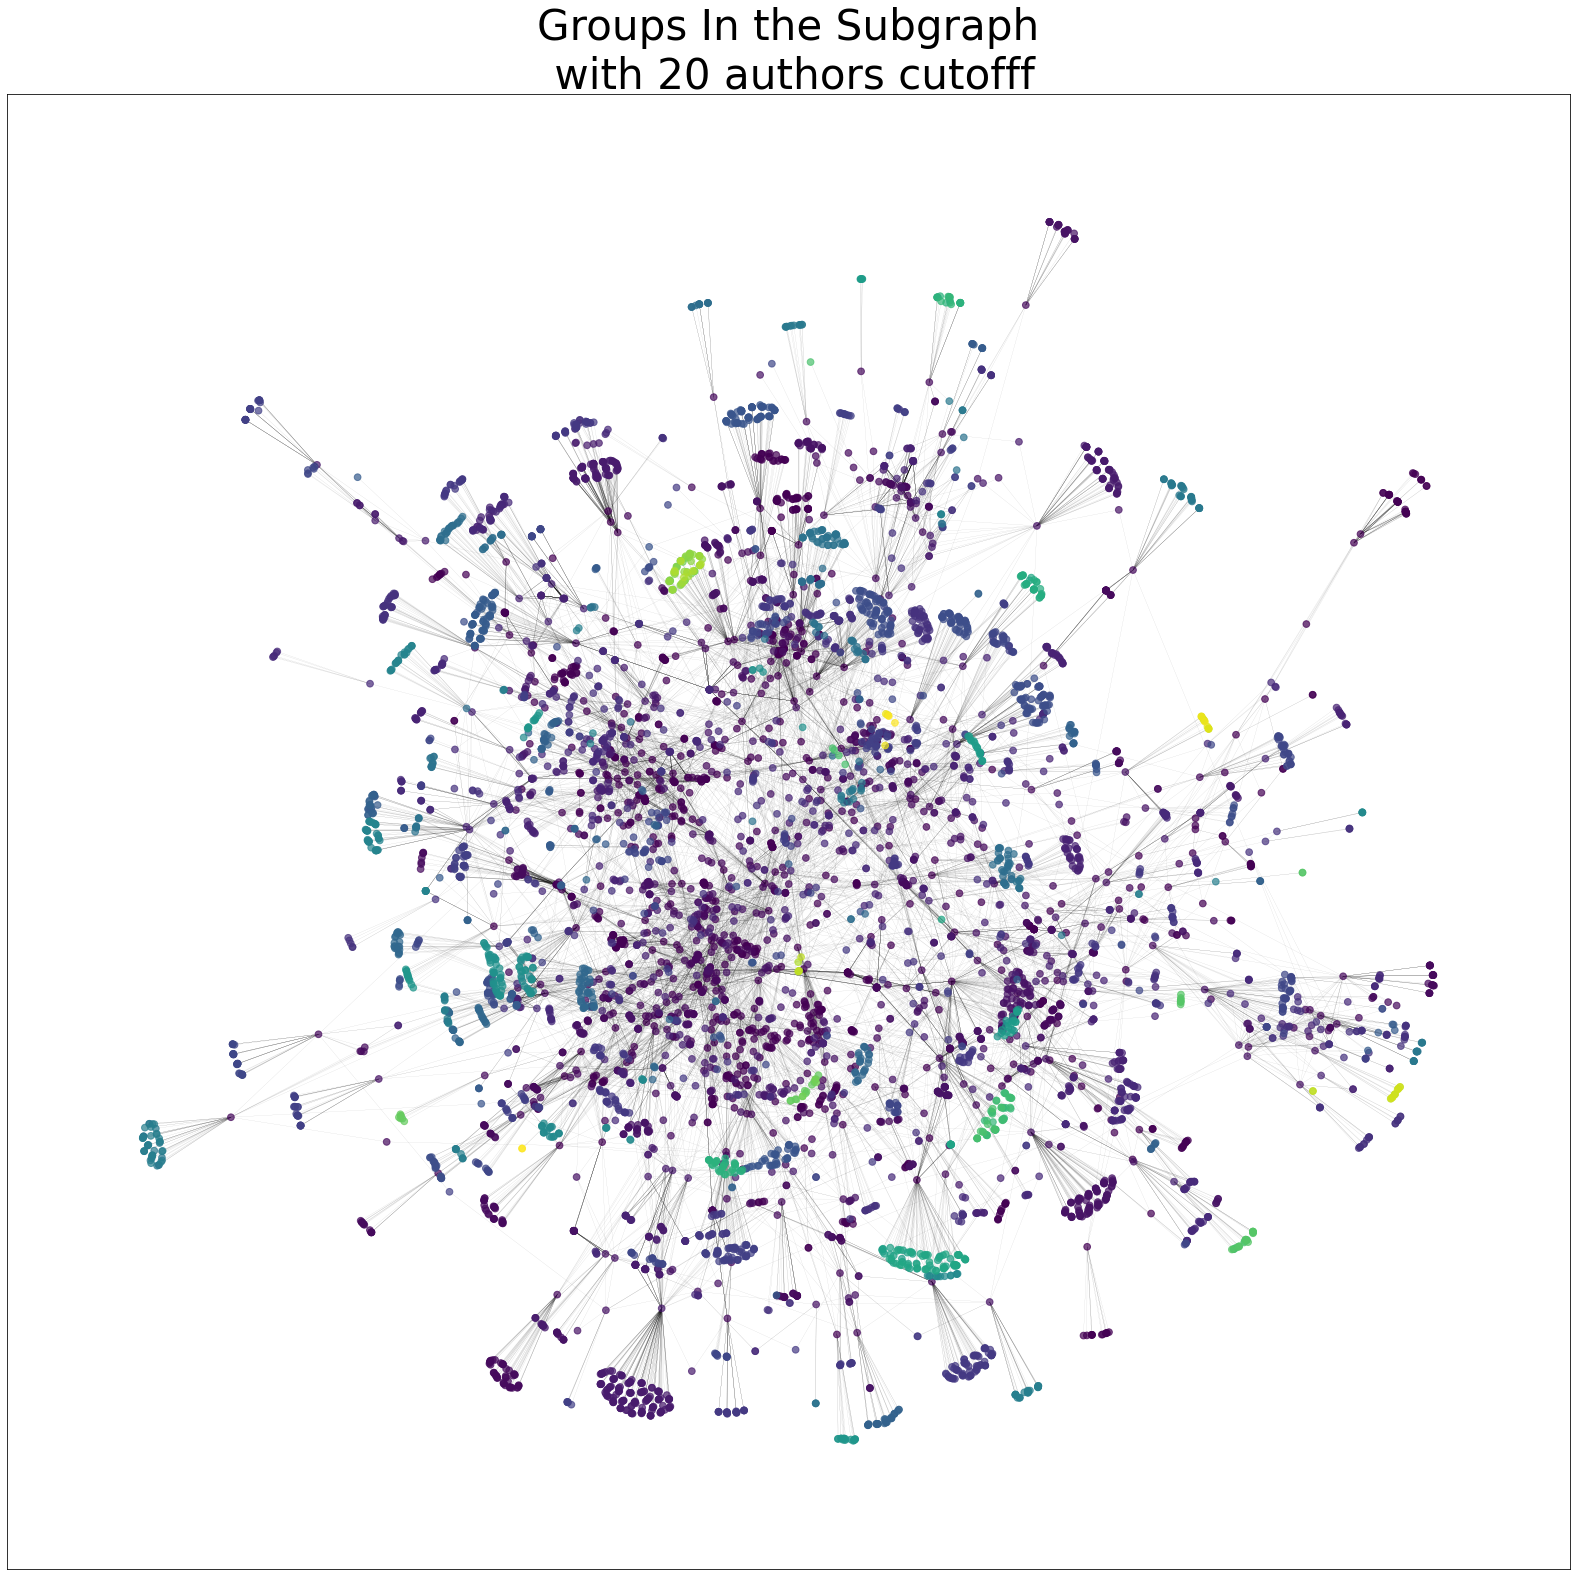

In [117]:
#get the figure
fig = plt.figure(figsize=(22,22))

plt.title("Groups In the Subgraph\n with 20 authors cutofff", fontsize=42)
nx.draw_networkx_nodes(single_source_subgraph,
                      pos_simple,
                      #nodelist = np.array(single_source_subgraph.nodes),
                      node_size=45,
                      node_color=list(greedy_list_of_communities_dict.values()),
                      alpha=0.7
                      )
                       
nx.draw_networkx_edges(single_source_subgraph,
                      pos_simple,
                      width=0.1,
                      edgelist=np.array(single_source_subgraph.edges),
                      edge_color='black',
                      alpha=0.4,
                      arrows=False)

fig.tight_layout()

plt.savefig("figs/group_searching_greedy_modularity_b.pdf", format="pdf", bbox_inches="tight")

#needs some modifications, but starts to look acceptable

plt.show()

**NOTE**: So it seems like there is no good way to draw this network, and because there is too many little groups, which means there is room for improvement

# Embeddings

Embeddings will be used here, later on

# Git commit stuff

In [2]:
!git add .
!git commit -m "2022/04/20: multiprocessing finishing line"
!git push origin master

The file will have its original line endings in your working directory
The file will have its original line endings in your working directory


[master 822bf14] 2022/04/20: multiprocessing finishing line
 2 files changed, 64 insertions(+), 116 deletions(-)


To https://github.com/AdamGTaylor/ScientificModelling2021-2022-2
   7132394..822bf14  master -> master


In [132]:
asd = list(np.array([1,2,3,4]))

asd

[1, 2, 3, 4]